#attention mechanism

In [4]:
import csv
import numpy as np
import re
import os
import pandas as pd
import matplotlib.pyplot as plt

eval_data_targets ={'none': 668, 'women': 151, 'african': 310, 'refugee': 77, 'islam': 204, 'homosexual': 182, 
                    'jewish': 186, 'disability': 4, 'caucasian': 48, 'other': 84, 'hispanic': 35, 'arab': 77, 
                    'asian': 34, 'christian': 3, 'men': 6}

def calculateF1Score(per_label_F1):
    weighted = 0
    count = 0
    macro = 0
    label_count = 0
    for label in eval_data_targets:
        if label == "none" or label not in per_label_F1:
            continue
        count += eval_data_targets[label]
        label_count += 1
        weighted += eval_data_targets[label] * per_label_F1[label]
        macro += per_label_F1[label]
    
    weighted = weighted / count if count > 0 else 0
    macro = macro / label_count if label_count > 0 else 0
    return weighted, macro



{'hate_speech': [0.76, 0.84, 0.79, 0.74, 0.88], 'normal': [0.76, 0.77, 0.76, 0.77, 0.76], 'offensive': [0.51, 0.54, 0.54, 0.54, 0.48]}
{'f1_scores': [0.7084565332409696, 0.7438062577763219, 0.7427932899986488, 0.7392512854706342, 0.7353070788626372], 'macro_f1_scores': [0.5057288189326068, 0.5348706508661546, 0.5353247165477523, 0.5263830238057302, 0.5216966754655614]}


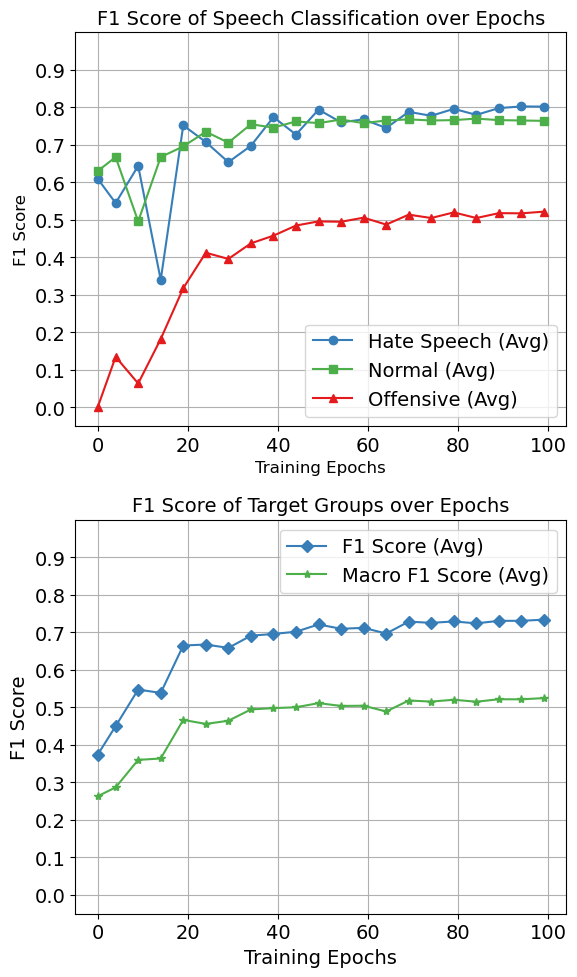

In [5]:
import csv
import re
import matplotlib.pyplot as plt
import os
import numpy as np

# CSV file path
directory_path = "logs/pfl_final_best/"

###############################################################################
# 1. Helper functions
###############################################################################

def extract_local_epoch(checkpoint_path):
    """Extracts the integer from 'checkpoint-<integer>' in the path."""
    match = re.search(r"checkpoint-(\d+)", checkpoint_path)
    return int(match.group(1)) if match else None

###############################################################################
# 2. We'll aggregate two sets of data:
#    (a) 3-class F1 from classification report lines
#    (b) Single + Macro F1 from columns in the CSV
###############################################################################
aggregated_3class = {}  # { local_step: {"hate_speech": [], "normal": [], "offensive": []} }
aggregated_single = {}  # { local_step: {"f1_scores": [], "macro_f1_scores": []} }

###############################################################################
# 3. Single pass over the CSV
###############################################################################
for filename in os.listdir(directory_path):
    csv_file_path = os.path.join(directory_path, filename)
    if filename.startswith("."):
        continue
    with open(csv_file_path, mode="r", encoding="utf-8") as file:
        reader = csv.DictReader(file)
        for row in reader:
            checkpoint_path = row.get("Checkpoint Path", "")
            if not checkpoint_path:
                continue

            # Extract local_step from checkpoint path
            local_epoch = extract_local_epoch(checkpoint_path)
            if local_epoch is None:
                continue

            # (a) Parse classification_report for hate/normal/offensive
            classification_report = row.get("Classification Report", "")
            if classification_report:
                # We'll search for lines with "hate speech", "normal", "offensive" 
                # and the 4th column is typically the F1 (index 3)
                f1_scores = {}
                for line in classification_report.split("\n"):
                    if "hate speech" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["hate_speech"] = float(parts[3])
                    elif "normal" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["normal"] = float(parts[3])
                    elif "offensive" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["offensive"] = float(parts[3])

                # If all three are found, store them
                if len(f1_scores) == 3:
                    if local_epoch not in aggregated_3class:
                        aggregated_3class[local_epoch] = {
                            "hate_speech": [],
                            "normal": [],
                            "offensive": []
                        }
                    aggregated_3class[local_epoch]["hate_speech"].append(f1_scores["hate_speech"])
                    aggregated_3class[local_epoch]["normal"].append(f1_scores["normal"])
                    aggregated_3class[local_epoch]["offensive"].append(f1_scores["offensive"])

            # (b) Parse single F1 + Macro F1 from CSV columns (if they exist)
            try:
                per_label = ast.literal_eval(row["Per Label F1"])
                f1_score, macro_f1_score = calculateF1Score(per_label)
            except (ValueError, KeyError):
                print("does not exist")
                # If columns are missing or not numeric, skip
                continue

            if local_epoch not in aggregated_single:
                aggregated_single[local_epoch] = {
                    "f1_scores": [],
                    "macro_f1_scores": []
                }
            aggregated_single[local_epoch]["f1_scores"].append(f1_score)
            aggregated_single[local_epoch]["macro_f1_scores"].append(macro_f1_score)

###############################################################################
# 4. Insert your "initial" data at local_step=0 if desired
###############################################################################
# For example, from your code snippet:
# (a) 3-class initial F1
initial_3class = {"hate_speech": 0.61, "normal": 0.63, "offensive": 0.0}
aggregated_3class[0] = {
    "hate_speech": [initial_3class["hate_speech"]],
    "normal": [initial_3class["normal"]],
    "offensive": [initial_3class["offensive"]]
}
print(aggregated_3class[99])
# (b) Single F1 initial
aggregated_single[0] = {
    "f1_scores": [0.37347886270248776],
    "macro_f1_scores": [0.26300220119753553]
}
print(aggregated_single[99])
df1 = pd.DataFrame(aggregated_3class[99])

df2 = pd.DataFrame(aggregated_single[99])

# Concatenate vertically
df_combined = pd.concat([df1, df2], axis=1)

# Save to CSV
df_combined.to_csv("pfl.csv", index=False)
###############################################################################
# 5. Compute averaged results from each dictionary and sort by local_step
###############################################################################
# 5. Compute averaged and median results from each dictionary and sort by local_step
results_3class = []
for epoch, dict_scores in aggregated_3class.items():
    hs_list = dict_scores["hate_speech"]
    normal_list = dict_scores["normal"]
    off_list = dict_scores["offensive"]
    results_3class.append({
        "local_epoch": epoch,
        "hate_speech_avg": np.mean(hs_list),
        # "hate_speech_med": np.median(hs_list),
        "normal_avg": np.mean(normal_list),
        # "normal_med": np.median(normal_list),
        "offensive_avg": np.mean(off_list),
        # "offensive_med": np.median(off_list)
    })
results_3class.sort(key=lambda x: x["local_epoch"])

results_single = []
for epoch, dict_scores in aggregated_single.items():
    f1_list = dict_scores["f1_scores"]
    macro_f1_list = dict_scores["macro_f1_scores"]
    results_single.append({
        "local_epoch": epoch,
        "f1_avg": np.mean(f1_list),
        # "f1_med": np.median(f1_list),
        "macro_avg": np.mean(macro_f1_list),
        # "macro_med": np.median(macro_f1_list),
    })
results_single.sort(key=lambda x: x["local_epoch"])

# 6. Prepare data for plotting
epochs_3class_pfl = [item["local_epoch"] for item in results_3class]
f1_hate_avg_pfl = [item["hate_speech_avg"] for item in results_3class]
# f1_hate_med = [item["hate_speech_med"] for item in results_3class]
f1_normal_avg_pfl = [item["normal_avg"] for item in results_3class]
# f1_normal_med = [item["normal_med"] for item in results_3class]
f1_off_avg_pfl = [item["offensive_avg"] for item in results_3class]
# f1_off_med = [item["offensive_med"] for item in results_3class]

epochs_single_pfl = [item["local_epoch"] for item in results_single]
f1_score_avg_pfl = [item["f1_avg"] for item in results_single]
# f1_score_med = [item["f1_med"] for item in results_single]
f1_macro_avg_pfl = [item["macro_avg"] for item in results_single]
# f1_macro_med = [item["macro_med"] for item in results_single]

# 8. Plot with colorblind-friendly colors and distinct markers/linestyles
fig, axs = plt.subplots(2, 1, figsize=(6, 10))

colors = ['#377eb8', '#4daf4a', '#e41a1c']  # blue, green, red
linestyles = ['-', '--']
markers = ['o', 's', '^', 'D', '*']

# -- LEFT SUBPLOT: 3-class F1
ax_left = axs[0]
ax_left.plot(epochs_3class_pfl, f1_hate_avg_pfl, label="Hate Speech (Avg)", marker=markers[0], linestyle=linestyles[0], color=colors[0])
# ax_left.plot(epochs_3class, f1_hate_med, label="Hate Speech (Med)", marker=markers[0], linestyle=linestyles[1], color=colors[0])

ax_left.plot(epochs_3class_pfl, f1_normal_avg_pfl, label="Normal (Avg)", marker=markers[1], linestyle=linestyles[0], color=colors[1])
# ax_left.plot(epochs_3class, f1_normal_med, label="Normal (Med)", marker=markers[1], linestyle=linestyles[1], color=colors[1])

ax_left.plot(epochs_3class_pfl, f1_off_avg_pfl, label="Offensive (Avg)", marker=markers[2], linestyle=linestyles[0], color=colors[2])
# ax_left.plot(epochs_3class, f1_off_med, label="Offensive (Med)", marker=markers[2], linestyle=linestyles[1], color=colors[2])

ax_left.set_title("F1 Score of Speech Classification over Epochs", fontsize=14)
ax_left.set_xlabel("Training Epochs", fontsize=12)
ax_left.set_ylabel("F1 Score", fontsize=12)
ax_left.set_ylim(-0.05, 1.0)
ax_left.set_yticks(np.arange(0, 1.0, 0.1))
ax_left.legend()
ax_left.grid(True)

# -- RIGHT SUBPLOT: Target Groups F1
ax_right = axs[1]
ax_right.plot(epochs_single_pfl, f1_score_avg_pfl, label="F1 Score (Avg)", marker=markers[3], linestyle=linestyles[0], color=colors[0])
# ax_right.plot(epochs_single, f1_score_med, label="Target Groups F1 (Med)", marker=markers[3], linestyle=linestyles[1], color=colors[0])

ax_right.plot(epochs_single_pfl, f1_macro_avg_pfl, label="Macro F1 Score (Avg)", marker=markers[4], linestyle=linestyles[0], color=colors[1])
# ax_right.plot(epochs_single, f1_macro_med, label="Macro F1 (Med)", marker=markers[4], linestyle=linestyles[1], color=colors[1])

ax_right.set_title("F1 Score of Target Groups over Epochs", fontsize=14)
ax_right.set_xlabel("Training Epochs", fontsize=14)
ax_right.set_ylabel("F1 Score", fontsize=14)
ax_right.set_ylim(-0.05, 1.0)
ax_right.set_yticks(np.arange(0, 1.0, 0.1))
ax_right.legend()
ax_right.grid(True)

plt.rcParams.update({
    'font.size': 14,             # base font size
    'axes.titlesize': 14,        # subplot titles
    'axes.labelsize': 14,        # x/y axis labels
    'xtick.labelsize': 14,       # x tick labels
    'ytick.labelsize': 14,       # y tick labels
    'legend.fontsize': 14,       # legend text
})

plt.tight_layout()
# plt.savefig("pfl_model.png", dpi=300, bbox_inches='tight')
plt.show()

[{'local_step': 0, 'hate_speech': 0.61, 'normal': 0.63, 'offensive': 0.0}, {'local_step': 481, 'hate_speech': 0.86, 'normal': 0.76, 'offensive': 0.45}, {'local_step': 962, 'hate_speech': 0.87, 'normal': 0.75, 'offensive': 0.53}, {'local_step': 1443, 'hate_speech': 0.68, 'normal': 0.76, 'offensive': 0.49}, {'local_step': 1924, 'hate_speech': 0.79, 'normal': 0.72, 'offensive': 0.58}, {'local_step': 2405, 'hate_speech': 0.69, 'normal': 0.71, 'offensive': 0.55}, {'local_step': 4810, 'hate_speech': 0.75, 'normal': 0.75, 'offensive': 0.47}, {'local_step': 7215, 'hate_speech': 0.86, 'normal': 0.7, 'offensive': 0.52}, {'local_step': 9620, 'hate_speech': 0.8, 'normal': 0.73, 'offensive': 0.52}, {'local_step': 12025, 'hate_speech': 0.71, 'normal': 0.73, 'offensive': 0.54}, {'local_step': 14430, 'hate_speech': 0.78, 'normal': 0.73, 'offensive': 0.5}, {'local_step': 16835, 'hate_speech': 0.71, 'normal': 0.72, 'offensive': 0.5}, {'local_step': 19240, 'hate_speech': 0.74, 'normal': 0.73, 'offensive'

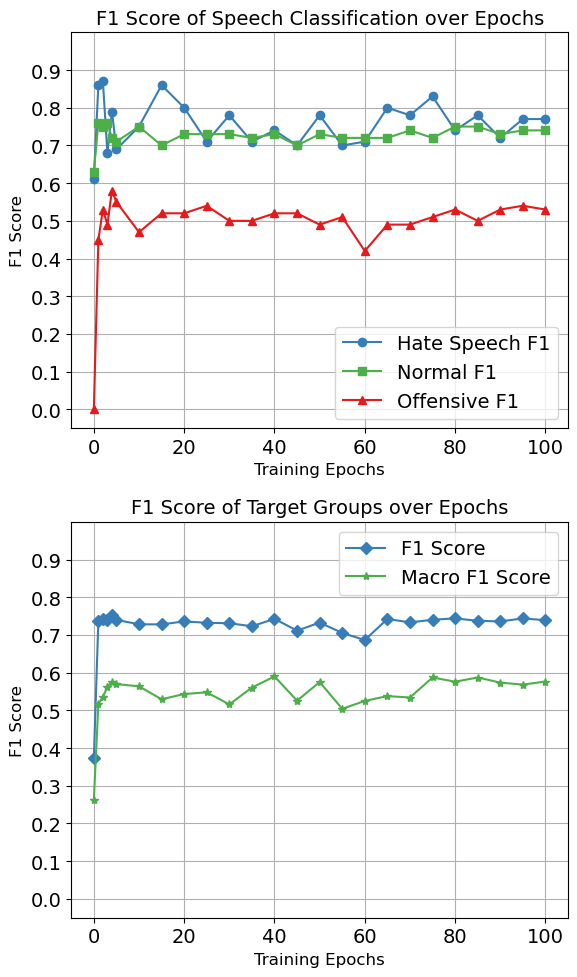

In [8]:
import csv
import re
import ast
import matplotlib.pyplot as plt

# CSV file path
csv_file_path = "logs/central_learning/peft_attention_evaluation.csv"

###############################################################################
# 1. Helper functions
###############################################################################
def local_step_to_epoch(local_step, batch_size, dataset_size):
    """Converts local_step to approximate epoch."""
    return (local_step * batch_size) / dataset_size

def extract_local_step(checkpoint_path):
    """Extracts the integer from 'checkpoint-<integer>' in the path."""
    match = re.search(r"checkpoint-(\d+)", checkpoint_path)
    return int(match.group(1)) if match else None

###############################################################################
# 2. We'll aggregate two sets of data:
#    (a) 3-class F1 from classification report lines
#    (b) Single + Macro F1 from columns in the CSV
###############################################################################
aggregated_3class = {}  # { local_step: {"hate_speech": [], "normal": [], "offensive": []} }
aggregated_single = {}  # { local_step: {"f1_scores": [], "macro_f1_scores": []} }

###############################################################################
# 3. Single pass over the CSV
###############################################################################
with open(csv_file_path, mode="r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    for row in reader:
        checkpoint_path = row.get("Checkpoint Path", "")
        if not checkpoint_path:
            continue
        
        # Extract local_step from checkpoint path
        local_step = extract_local_step(checkpoint_path)
        if local_step is None:
            continue
        
        # (a) Parse classification_report for hate/normal/offensive
        classification_report = row.get("Classification Report", "")
        if classification_report:
            # We'll search for lines with "hate speech", "normal", "offensive" 
            # and the 4th column is typically the F1 (index 3)
            f1_scores = {}
            for line in classification_report.split("\n"):
                if "hate speech" in line:
                    parts = line.split()
                    if len(parts) >= 4:
                        f1_scores["hate_speech"] = float(parts[3])
                elif "normal" in line:
                    parts = line.split()
                    if len(parts) >= 4:
                        f1_scores["normal"] = float(parts[3])
                elif "offensive" in line:
                    parts = line.split()
                    if len(parts) >= 4:
                        f1_scores["offensive"] = float(parts[3])
            
            # If all three are found, store them
            if len(f1_scores) == 3:
                if local_step not in aggregated_3class:
                    aggregated_3class[local_step] = {
                        "hate_speech": [],
                        "normal": [],
                        "offensive": []
                    }
                aggregated_3class[local_step]["hate_speech"].append(f1_scores["hate_speech"])
                aggregated_3class[local_step]["normal"].append(f1_scores["normal"])
                aggregated_3class[local_step]["offensive"].append(f1_scores["offensive"])
        
        # (b) Parse single F1 + Macro F1 from CSV columns (if they exist)
        try:
            # f1_score = float(row["F1 Score"])
            # macro_f1_score = float(row["Macro F1 Score"])
            per_label = ast.literal_eval(row["Per Label F1"])
            f1_score, macro_f1_score = calculateF1Score(per_label)

        except (ValueError, KeyError):
            # If columns are missing or not numeric, skip
            continue
        
        if local_step not in aggregated_single:
            aggregated_single[local_step] = {
                "f1_scores": [],
                "macro_f1_scores": []
            }
        aggregated_single[local_step]["f1_scores"].append(f1_score)
        aggregated_single[local_step]["macro_f1_scores"].append(macro_f1_score)

###############################################################################
# 4. Insert your "initial" data at local_step=0 if desired
###############################################################################
# For example, from your code snippet:
# (a) 3-class initial F1
initial_3class = {"hate_speech": 0.61, "normal": 0.63, "offensive": 0.0}
aggregated_3class[0] = {
    "hate_speech": [initial_3class["hate_speech"]],
    "normal": [initial_3class["normal"]],
    "offensive": [initial_3class["offensive"]]
}

# (b) Single F1 initial
aggregated_single[0] = {
    "f1_scores": [0.37347886270248776],
    "macro_f1_scores": [0.26300220119753553]
}

###############################################################################
# 5. Compute averaged results from each dictionary and sort by local_step
###############################################################################
results_3class = []
for step, dict_scores in aggregated_3class.items():
    hs_list = dict_scores["hate_speech"]
    normal_list = dict_scores["normal"]
    off_list = dict_scores["offensive"]
    results_3class.append({
        "local_step": step,
        "hate_speech": sum(hs_list) / len(hs_list),
        "normal": sum(normal_list) / len(normal_list),
        "offensive": sum(off_list) / len(off_list)
    })

results_3class.sort(key=lambda x: x["local_step"])
print(results_3class)
results_single = []
for step, dict_scores in aggregated_single.items():
    f1_list = dict_scores["f1_scores"]
    macro_f1_list = dict_scores["macro_f1_scores"]
    results_single.append({
        "local_step": step,
        "F1 Score": sum(f1_list) / len(f1_list),
        "Macro F1 Score": sum(macro_f1_list) / len(macro_f1_list)
    })

results_single.sort(key=lambda x: x["local_step"])
print(results_single)
###############################################################################
# 6. Prepare data for plotting
###############################################################################
# For 3-class
steps_3class = [item["local_step"] for item in results_3class]
f1_hate_speech = [item["hate_speech"] for item in results_3class]
f1_normal = [item["normal"] for item in results_3class]
f1_offensive = [item["offensive"] for item in results_3class]

# For single F1 + Macro F1
steps_single = [item["local_step"] for item in results_single]
f1_score_vals = [item["F1 Score"] for item in results_single]
f1_macro_vals = [item["Macro F1 Score"] for item in results_single]

###############################################################################
# 7. (Optional) Convert local_steps to epochs if you want epochs on the X-axis
###############################################################################
# Example:
dataset_size = 15383
batch_size = 32
epochs_3class = [local_step_to_epoch(s, batch_size, dataset_size) for s in steps_3class]
epochs_single = [local_step_to_epoch(s, batch_size, dataset_size) for s in steps_single]

###############################################################################
# 8. Plot side by side in a single figure with two subplots
###############################################################################

# -- LEFT SUBPLOT: 3-class F1 lines
# Define colorblind-friendly palette and distinct markers
colors = ['#377eb8', '#4daf4a', '#e41a1c']  # blue, green, red
markers = ['o', 's', '^', 'D', '*']

fig, axs = plt.subplots(2, 1, figsize=(6, 10))

# -- LEFT SUBPLOT: 3-class F1
ax_left = axs[0]
ax_left.plot(epochs_3class, f1_hate_speech, label="Hate Speech F1", marker=markers[0], color=colors[0])
ax_left.plot(epochs_3class, f1_normal, label="Normal F1", marker=markers[1], color=colors[1])
ax_left.plot(epochs_3class, f1_offensive, label="Offensive F1", marker=markers[2], color=colors[2])

ax_left.set_title("F1 Score of Speech Classification over Epochs", fontsize=14)
ax_left.set_xlabel("Training Epochs", fontsize=12)
ax_left.set_ylabel("F1 Score", fontsize=12)
ax_left.set_ylim(-0.05, 1.0)
ax_left.set_yticks(np.arange(0, 1.0, 0.1))

ax_left.legend()
ax_left.grid(True)

# -- RIGHT SUBPLOT: single F1 + Macro F1 lines
ax_right = axs[1]
ax_right.plot(epochs_single, f1_score_vals, label="F1 Score", marker=markers[3], color=colors[0])
ax_right.plot(epochs_single, f1_macro_vals, label="Macro F1 Score", marker=markers[4], color=colors[1])

ax_right.set_title("F1 Score of Target Groups over Epochs", fontsize=14)
ax_right.set_xlabel("Training Epochs", fontsize=12)
ax_right.set_ylabel("F1 Score", fontsize=12)
ax_right.set_ylim(-0.05, 1.0)
ax_right.set_yticks(np.arange(0, 1.0, 0.1))
ax_right.legend()
ax_right.grid(True)

plt.rcParams.update({
    'font.size': 14,             # base font size
    'axes.titlesize': 14,        # subplot titles
    'axes.labelsize': 14,        # x/y axis labels
    'xtick.labelsize': 14,       # x tick labels
    'ytick.labelsize': 14,       # y tick labels
    'legend.fontsize': 14,       # legend text
})
plt.tight_layout()
plt.savefig("central_model.png", dpi=300, bbox_inches='tight')
plt.show()


{'hate_speech': [0.73], 'normal': [0.75], 'offensive': [0.5]}
{'f1_scores': [0.7151973990642602], 'macro_f1_scores': [0.5263141916735146], 'word_f1_scores': [0.4797297297297297], 'word_precision': [0.6516360734237829], 'word_recall': [0.3795908879590888]}
[{'local_step': 0, 'hate_speech': 0.61, 'normal': 0.63, 'offensive': 0.0}, {'local_step': 241, 'hate_speech': 0.69, 'normal': 0.75, 'offensive': 0.36}, {'local_step': 482, 'hate_speech': 0.83, 'normal': 0.77, 'offensive': 0.45}, {'local_step': 723, 'hate_speech': 0.58, 'normal': 0.78, 'offensive': 0.45}, {'local_step': 964, 'hate_speech': 0.73, 'normal': 0.74, 'offensive': 0.57}, {'local_step': 1205, 'hate_speech': 0.66, 'normal': 0.77, 'offensive': 0.53}, {'local_step': 2410, 'hate_speech': 0.76, 'normal': 0.75, 'offensive': 0.55}, {'local_step': 3615, 'hate_speech': 0.79, 'normal': 0.77, 'offensive': 0.5}, {'local_step': 4820, 'hate_speech': 0.62, 'normal': 0.74, 'offensive': 0.52}, {'local_step': 6025, 'hate_speech': 0.82, 'normal'

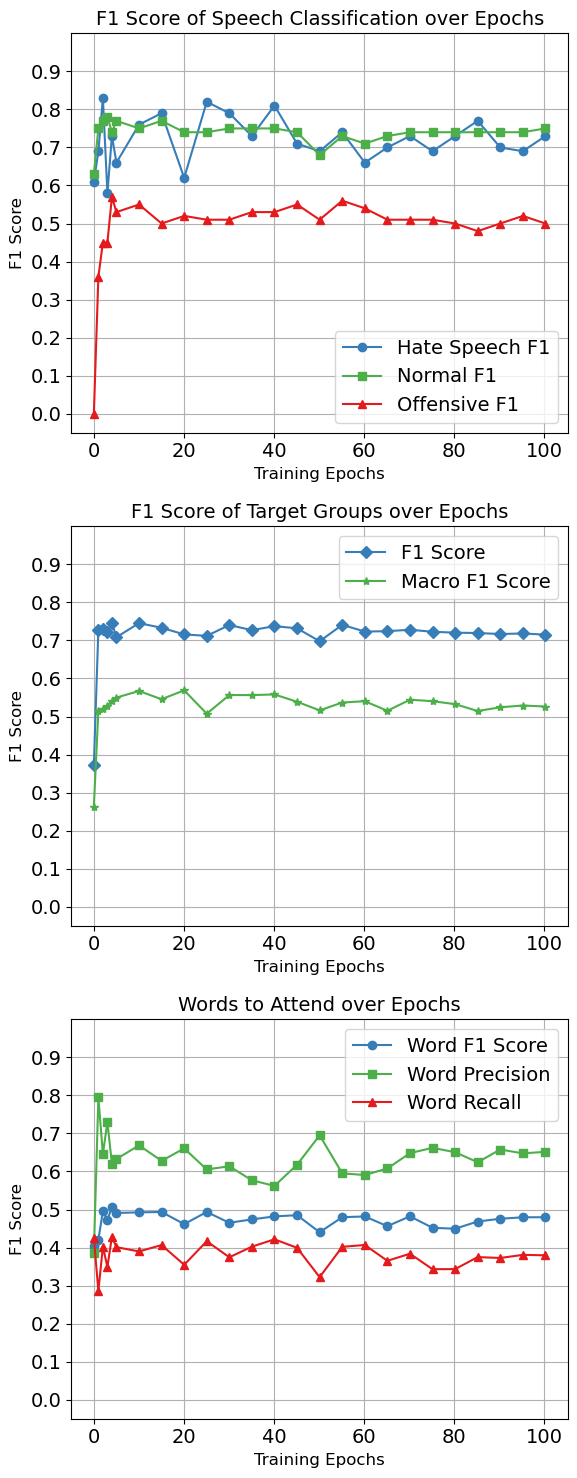

In [28]:
import csv
import re
import ast
import matplotlib.pyplot as plt

# CSV file path
csv_file_path = "logs/central_learning/mistral_attention_new.csv"

###############################################################################
# 1. Helper functions
###############################################################################
def local_step_to_epoch(local_step, batch_size, dataset_size):
    """Converts local_step to approximate epoch."""
    return (local_step * batch_size) / dataset_size

def extract_local_step(checkpoint_path):
    """Extracts the integer from 'checkpoint-<integer>' in the path."""
    match = re.search(r"checkpoint-(\d+)", checkpoint_path)
    return int(match.group(1)) if match else None

###############################################################################
# 2. We'll aggregate two sets of data:
#    (a) 3-class F1 from classification report lines
#    (b) Single + Macro F1 from columns in the CSV
###############################################################################
aggregated_3class = {}  # { local_step: {"hate_speech": [], "normal": [], "offensive": []} }
aggregated_single = {}  # { local_step: {"f1_scores": [], "macro_f1_scores": []} }

###############################################################################
# 3. Single pass over the CSV
###############################################################################
with open(csv_file_path, mode="r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    for row in reader:
        checkpoint_path = row.get("Checkpoint Path", "")
        if not checkpoint_path:
            continue
        
        # Extract local_step from checkpoint path
        local_step = extract_local_step(checkpoint_path)
        if local_step is None:
            continue
        
        # (a) Parse classification_report for hate/normal/offensive
        classification_report = row.get("Classification Report", "")
        if classification_report:
            # We'll search for lines with "hate speech", "normal", "offensive" 
            # and the 4th column is typically the F1 (index 3)
            f1_scores = {}
            for line in classification_report.split("\n"):
                if "hate speech" in line:
                    parts = line.split()
                    if len(parts) >= 4:
                        f1_scores["hate_speech"] = float(parts[3])
                elif "normal" in line:
                    parts = line.split()
                    if len(parts) >= 4:
                        f1_scores["normal"] = float(parts[3])
                elif "offensive" in line:
                    parts = line.split()
                    if len(parts) >= 4:
                        f1_scores["offensive"] = float(parts[3])
            
            # If all three are found, store them
            if len(f1_scores) == 3:
                if local_step not in aggregated_3class:
                    aggregated_3class[local_step] = {
                        "hate_speech": [],
                        "normal": [],
                        "offensive": []
                    }
                aggregated_3class[local_step]["hate_speech"].append(f1_scores["hate_speech"])
                aggregated_3class[local_step]["normal"].append(f1_scores["normal"])
                aggregated_3class[local_step]["offensive"].append(f1_scores["offensive"])
        
        # (b) Parse single F1 + Macro F1 from CSV columns (if they exist)
        try:
            # f1_score = float(row["F1 Score"])
            # macro_f1_score = float(row["Macro F1 Score"])
            per_label = ast.literal_eval(row["Per Label F1"])
            f1_score, macro_f1_score = calculateF1Score(per_label)
            word_f1_score = float(row["Word F1 Score"])
            word_precision = float(row["Word Overall Precision"])
            word_recall = float(row["Word Overall Recall"])

        except (ValueError, KeyError):
            # If columns are missing or not numeric, skip
            continue
        
        if local_step not in aggregated_single:
            aggregated_single[local_step] = {
                "f1_scores": [],
                "macro_f1_scores": [],
                "word_f1_scores": [],
                "word_precision": [],
                "word_recall":[]
            }
        aggregated_single[local_step]["f1_scores"].append(f1_score)
        aggregated_single[local_step]["macro_f1_scores"].append(macro_f1_score)
        aggregated_single[local_step]["word_f1_scores"].append(word_f1_score)
        aggregated_single[local_step]["word_precision"].append(word_precision)
        aggregated_single[local_step]["word_recall"].append(word_recall)

###############################################################################
# 4. Insert your "initial" data at local_step=0 if desired
###############################################################################
# For example, from your code snippet:
# (a) 3-class initial F1
initial_3class = {"hate_speech": 0.61, "normal": 0.63, "offensive": 0.0}
aggregated_3class[0] = {
    "hate_speech": [initial_3class["hate_speech"]],
    "normal": [initial_3class["normal"]],
    "offensive": [initial_3class["offensive"]]
}

# (b) Single F1 initial
aggregated_single[0] = {
    "f1_scores": [0.37347886270248776],
    "macro_f1_scores": [0.26300220119753553],
    "word_f1_scores":[0.4046881910659],
    "word_precision":[0.38591311682834245],
    "word_recall":[0.42538354253835425]
}
print(aggregated_3class[24100])
print(aggregated_single[24100])

df1 = pd.DataFrame(aggregated_3class[24100])

df2 = pd.DataFrame(aggregated_single[24100])

# Concatenate vertically
df_combined = pd.concat([df1, df2], axis=1)

# Save to CSV
df_combined.to_csv("central_model_new.csv", index=False)
###############################################################################
# 5. Compute averaged results from each dictionary and sort by local_step
###############################################################################
results_3class = []
for step, dict_scores in aggregated_3class.items():
    hs_list = dict_scores["hate_speech"]
    normal_list = dict_scores["normal"]
    off_list = dict_scores["offensive"]
    results_3class.append({
        "local_step": step,
        "hate_speech": sum(hs_list) / len(hs_list),
        "normal": sum(normal_list) / len(normal_list),
        "offensive": sum(off_list) / len(off_list)
    })

results_3class.sort(key=lambda x: x["local_step"])
print(results_3class)
results_single = []
for step, dict_scores in aggregated_single.items():
    f1_list = dict_scores["f1_scores"]
    macro_f1_list = dict_scores["macro_f1_scores"]
    word_f1_list = dict_scores["word_f1_scores"]
    word_precision_list = dict_scores["word_precision"]
    word_recall_list = dict_scores["word_recall"]
    results_single.append({
        "local_step": step,
        "F1 Score": sum(f1_list) / len(f1_list),
        "Macro F1 Score": sum(macro_f1_list) / len(macro_f1_list),
        "Word F1 Score": sum(word_f1_list)/len(word_f1_list),
        "Word Precision": sum(word_precision_list)/len(word_precision_list),
        "Word Recall": sum(word_recall_list)/len(word_recall_list)
    })

results_single.sort(key=lambda x: x["local_step"])
###############################################################################
# 6. Prepare data for plotting
###############################################################################
# For 3-class
steps_3class_new = [item["local_step"] for item in results_3class]
f1_hate_speech_new = [item["hate_speech"] for item in results_3class]
f1_normal_new = [item["normal"] for item in results_3class]
f1_offensive_new = [item["offensive"] for item in results_3class]

# For single F1 + Macro F1
steps_single_new = [item["local_step"] for item in results_single]
f1_score_vals_new = [item["F1 Score"] for item in results_single]
f1_macro_vals_new = [item["Macro F1 Score"] for item in results_single]
word_f1_score_vals_new = [item["Word F1 Score"] for item in results_single]
word_precision_vals_new = [item["Word Precision"] for item in results_single]
word_recall_vals_new = [item["Word Recall"] for item in results_single]
###############################################################################
# 7. (Optional) Convert local_steps to epochs if you want epochs on the X-axis
###############################################################################
# Example:
dataset_size = 15383
batch_size = 64
epochs_3class_new = [local_step_to_epoch(s, batch_size, dataset_size) for s in steps_3class_new]
epochs_single_new = [local_step_to_epoch(s, batch_size, dataset_size) for s in steps_single_new]

###############################################################################
# 8. Plot side by side in a single figure with two subplots
###############################################################################

# -- LEFT SUBPLOT: 3-class F1 lines
# Define colorblind-friendly palette and distinct markers
colors = ['#377eb8', '#4daf4a', '#e41a1c']  # blue, green, red
markers = ['o', 's', '^', 'D', '*']

fig, axs = plt.subplots(3, 1, figsize=(6, 15))
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1))


# -- LEFT SUBPLOT: 3-class F1
ax = axs[0]
ax.plot(epochs_3class_new, f1_hate_speech_new, label="Hate Speech F1", marker=markers[0], color=colors[0])
ax.plot(epochs_3class_new, f1_normal_new, label="Normal F1", marker=markers[1], color=colors[1])
ax.plot(epochs_3class_new, f1_offensive_new, label="Offensive F1", marker=markers[2], color=colors[2])

ax.set_title("F1 Score of Speech Classification over Epochs", fontsize=14)
ax.set_xlabel("Training Epochs", fontsize=12)
ax.set_ylabel("F1 Score", fontsize=12)
ax.set_ylim(-0.05, 1.0)
ax.set_yticks(np.arange(0, 1.0, 0.1))

ax.legend()
ax.grid(True)

# -- RIGHT SUBPLOT: single F1 + Macro F1 lines
ax_right = axs[1]
ax_right.plot(epochs_single_new, f1_score_vals_new, label="F1 Score", marker=markers[3], color=colors[0])
ax_right.plot(epochs_single_new, f1_macro_vals_new, label="Macro F1 Score", marker=markers[4], color=colors[1])

ax_right.set_title("F1 Score of Target Groups over Epochs", fontsize=14)
ax_right.set_xlabel("Training Epochs", fontsize=12)
ax_right.set_ylabel("F1 Score", fontsize=12)
ax_right.set_ylim(-0.05, 1.0)
ax_right.set_yticks(np.arange(0, 1.0, 0.1))
ax_right.legend()
ax_right.grid(True)

#Words
ax_left = axs[2]
ax_left.plot(epochs_single_new, word_f1_score_vals_new, label="Word F1 Score", marker=markers[0], color=colors[0])
ax_left.plot(epochs_single_new, word_precision_vals_new, label="Word Precision", marker=markers[1], color=colors[1])
ax_left.plot(epochs_single_new, word_recall_vals_new, label="Word Recall", marker=markers[2], color=colors[2])

ax_left.set_title("Words to Attend over Epochs", fontsize=14)
ax_left.set_xlabel("Training Epochs", fontsize=12)
ax_left.set_ylabel("F1 Score", fontsize=12)
ax_left.set_ylim(-0.05, 1.0)
ax_left.set_yticks(np.arange(0, 1.0, 0.1))
ax_left.legend()
ax_left.grid(True)

plt.rcParams.update({
    'font.size': 14,             # base font size
    'axes.titlesize': 14,        # subplot titles
    'axes.labelsize': 14,        # x/y axis labels
    'xtick.labelsize': 14,       # x tick labels
    'ytick.labelsize': 14,       # y tick labels
    'legend.fontsize': 14,       # legend text
})
plt.tight_layout()
# plt.savefig("central_model.png", dpi=300, bbox_inches='tight')
plt.show()


{'hate_speech': [0.52, 0.62, 0.49, 0.63, 0.6], 'normal': [0.77, 0.76, 0.73, 0.74, 0.76], 'offensive': [0.5, 0.44, 0.3, 0.44, 0.41]}
{'f1_scores': [0.7183432029369876, 0.7041753248644954, 0.6248749469153193, 0.7210102592889736, 0.6904774315886306], 'macro_f1_scores': [0.5454102619221335, 0.4934805838750346, 0.43950826535910087, 0.5053355385789922, 0.4903575306030402], 'word_f1_scores': [0.48616780045351465, 0.4982562547384382, 0.4108792336640438, 0.4664723032069971, 0.4558033534103858], 'word_precision': [0.695201037613489, 0.71652856519843, 0.7778497409326425, 0.6862302483069977, 0.7604562737642585], 'word_recall': [0.3737796373779637, 0.3819153881915388, 0.2791724779172478, 0.35332403533240353, 0.32543003254300323]}


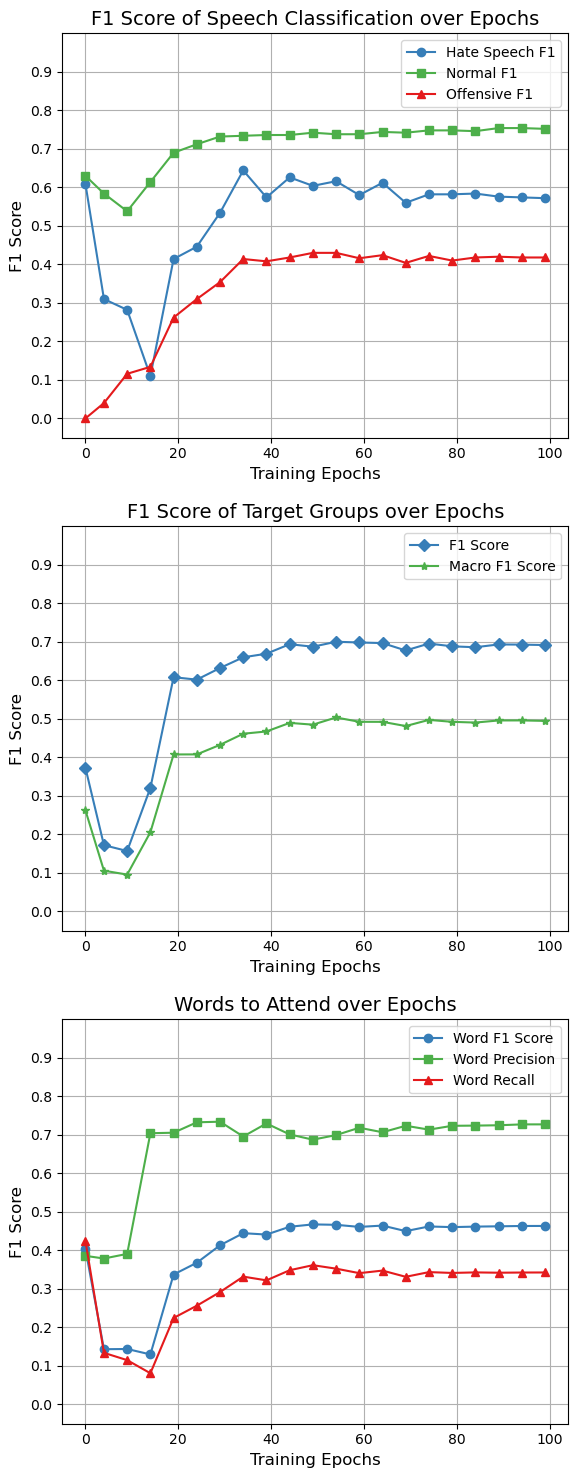

In [5]:
import csv
import re
import ast
import matplotlib.pyplot as plt
import os

# CSV file path
directory_path = "logs/fl_new/"

###############################################################################
# 1. Helper functions
###############################################################################
def extract_local_epoch(checkpoint_path):
    """Extracts the integer from 'checkpoint-<integer>' in the path."""
    match = re.search(r"checkpoint-(\d+)", checkpoint_path)
    return int(match.group(1)) if match else None

###############################################################################
# 2. We'll aggregate two sets of data:
#    (a) 3-class F1 from classification report lines
#    (b) Single + Macro F1 from columns in the CSV
###############################################################################
aggregated_3class = {}  # { local_step: {"hate_speech": [], "normal": [], "offensive": []} }
aggregated_single = {}  # { local_step: {"f1_scores": [], "macro_f1_scores": []} }

###############################################################################
# 3. Single pass over the CSV
###############################################################################
for filename in os.listdir(directory_path):
    csv_file_path = os.path.join(directory_path, filename)
    if filename.startswith("."):
        continue
    with open(csv_file_path, mode="r", encoding="utf-8") as file:
        reader = csv.DictReader(file)
        for row in reader:
            checkpoint_path = row.get("Checkpoint Path", "")
            if not checkpoint_path:
                continue

            # Extract local_step from checkpoint path
            local_epoch = extract_local_epoch(checkpoint_path)
            if local_epoch is None:
                continue

            # (a) Parse classification_report for hate/normal/offensive
            classification_report = row.get("Classification Report", "")
            if classification_report:
                # We'll search for lines with "hate speech", "normal", "offensive" 
                # and the 4th column is typically the F1 (index 3)
                f1_scores = {}
                for line in classification_report.split("\n"):
                    if "hate speech" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["hate_speech"] = float(parts[3])
                    elif "normal" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["normal"] = float(parts[3])
                    elif "offensive" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["offensive"] = float(parts[3])

                # If all three are found, store them
                if len(f1_scores) == 3:
                    if local_epoch not in aggregated_3class:
                        aggregated_3class[local_epoch] = {
                            "hate_speech": [],
                            "normal": [],
                            "offensive": []
                        }
                    aggregated_3class[local_epoch]["hate_speech"].append(f1_scores["hate_speech"])
                    aggregated_3class[local_epoch]["normal"].append(f1_scores["normal"])
                    aggregated_3class[local_epoch]["offensive"].append(f1_scores["offensive"])

            # (b) Parse single F1 + Macro F1 from CSV columns (if they exist)
            try:
                # f1_score = float(row["F1 Score"])
                # macro_f1_score = float(row["Macro F1 Score"])
                per_label = ast.literal_eval(row["Per Label F1"])
                f1_score, macro_f1_score = calculateF1Score(per_label)
                word_f1_score = float(row["Word F1 Score"])
                word_precision = float(row["Word Overall Precision"])
                word_recall = float(row["Word Overall Recall"])

            except (ValueError, KeyError):
                # If columns are missing or not numeric, skip
                continue

            if local_epoch not in aggregated_single:
                aggregated_single[local_epoch] = {
                    "f1_scores": [],
                    "macro_f1_scores": [],
                    "word_f1_scores": [],
                    "word_precision": [],
                    "word_recall":[]
                }
            aggregated_single[local_epoch]["f1_scores"].append(f1_score)
            aggregated_single[local_epoch]["macro_f1_scores"].append(macro_f1_score)
            aggregated_single[local_epoch]["word_f1_scores"].append(word_f1_score)
            aggregated_single[local_epoch]["word_precision"].append(word_precision)
            aggregated_single[local_epoch]["word_recall"].append(word_recall)

###############################################################################
# 4. Insert your "initial" data at local_step=0 if desired
###############################################################################
# For example, from your code snippet:
# (a) 3-class initial F1
initial_3class = {"hate_speech": 0.61, "normal": 0.63, "offensive": 0.0}
aggregated_3class[0] = {
    "hate_speech": [initial_3class["hate_speech"]],
    "normal": [initial_3class["normal"]],
    "offensive": [initial_3class["offensive"]]
}

# (b) Single F1 initial
aggregated_single[0] = {
    "f1_scores": [0.37347886270248776],
    "macro_f1_scores": [0.26300220119753553],
    "word_f1_scores":[0.4046881910659],
    "word_precision":[0.38591311682834245],
    "word_recall":[0.42538354253835425]
}

print(aggregated_3class[99])
print(aggregated_single[99])

df1 = pd.DataFrame(aggregated_3class[99])

df2 = pd.DataFrame(aggregated_single[99])

# Concatenate vertically
df_combined = pd.concat([df1, df2], axis=1)

# Save to CSV
df_combined.to_csv("fl_new.csv", index=False)
###############################################################################
# 5. Compute averaged results from each dictionary and sort by local_step
###############################################################################
results_3class = []
for epoch, dict_scores in aggregated_3class.items():
    hs_list = dict_scores["hate_speech"]
    normal_list = dict_scores["normal"]
    off_list = dict_scores["offensive"]
    results_3class.append({
        "local_epoch": epoch,
        "hate_speech": sum(hs_list) / len(hs_list),
        "normal": sum(normal_list) / len(normal_list),
        "offensive": sum(off_list) / len(off_list)
    })

results_3class.sort(key=lambda x: x["local_epoch"])
# print(results_3class)
results_single = []
for epoch, dict_scores in aggregated_single.items():
    f1_list = dict_scores["f1_scores"]
    macro_f1_list = dict_scores["macro_f1_scores"]
    word_f1_list = dict_scores["word_f1_scores"]
    word_precision_list = dict_scores["word_precision"]
    word_recall_list = dict_scores["word_recall"]
    results_single.append({
        "local_epoch": epoch,
        "F1 Score": sum(f1_list) / len(f1_list),
        "Macro F1 Score": sum(macro_f1_list) / len(macro_f1_list),
        "Word F1 Score": sum(word_f1_list)/len(word_f1_list),
        "Word Precision": sum(word_precision_list)/len(word_precision_list),
        "Word Recall": sum(word_recall_list)/len(word_recall_list)
    })

results_single.sort(key=lambda x: x["local_epoch"])
# print(results_single)
###############################################################################
# 6. Prepare data for plotting
###############################################################################
# For 3-class
epochs_3class_fl_new = [item["local_epoch"] for item in results_3class]
f1_hate_speech_fl_new = [item["hate_speech"] for item in results_3class]
f1_normal_fl_new = [item["normal"] for item in results_3class]
f1_offensive_fl_new = [item["offensive"] for item in results_3class]

# For single F1 + Macro F1
epochs_single_fl_new = [item["local_epoch"] for item in results_single]
f1_score_vals_fl_new = [item["F1 Score"] for item in results_single]
f1_macro_vals_fl_new = [item["Macro F1 Score"] for item in results_single]
word_f1_score_vals_fl_new = [item["Word F1 Score"] for item in results_single]
word_precision_vals_fl_new = [item["Word Precision"] for item in results_single]
word_recall_vals_fl_new = [item["Word Recall"] for item in results_single]
###############################################################################
# 7. (Optional) Convert local_steps to epochs if you want epochs on the X-axis
###############################################################################
# Example:
dataset_size = 15383
batch_size = 64

###############################################################################
# 8. Plot side by side in a single figure with two subplots
###############################################################################

# -- LEFT SUBPLOT: 3-class F1 lines
# Define colorblind-friendly palette and distinct markers
colors = ['#377eb8', '#4daf4a', '#e41a1c']  # blue, green, red
markers = ['o', 's', '^', 'D', '*']

fig, axs = plt.subplots(3, 1, figsize=(6, 15))

# -- LEFT SUBPLOT: 3-class F1
ax = axs[0]
ax.plot(epochs_3class_fl_new, f1_hate_speech_fl_new, label="Hate Speech F1", marker=markers[0], color=colors[0])
ax.plot(epochs_3class_fl_new, f1_normal_fl_new, label="Normal F1", marker=markers[1], color=colors[1])
ax.plot(epochs_3class_fl_new, f1_offensive_fl_new, label="Offensive F1", marker=markers[2], color=colors[2])

ax.set_title("F1 Score of Speech Classification over Epochs", fontsize=14)
ax.set_xlabel("Training Epochs", fontsize=12)
ax.set_ylabel("F1 Score", fontsize=12)
ax.set_ylim(-0.05, 1.0)
ax.set_yticks(np.arange(0, 1.0, 0.1))
ax.legend()
ax.grid(True)

# -- RIGHT SUBPLOT: single F1 + Macro F1 lines
ax_right = axs[1]
ax_right.plot(epochs_single_fl_new, f1_score_vals_fl_new, label="F1 Score", marker=markers[3], color=colors[0])
ax_right.plot(epochs_single_fl_new, f1_macro_vals_fl_new, label="Macro F1 Score", marker=markers[4], color=colors[1])

ax_right.set_title("F1 Score of Target Groups over Epochs", fontsize=14)
ax_right.set_xlabel("Training Epochs", fontsize=12)
ax_right.set_ylabel("F1 Score", fontsize=12)
ax_right.set_ylim(-0.05, 1.0)
ax_right.set_yticks(np.arange(0, 1.0, 0.1))
ax_right.legend()
ax_right.grid(True)

#Words
ax_left = axs[2]
ax_left.plot(epochs_single_fl_new, word_f1_score_vals_fl_new, label="Word F1 Score", marker=markers[0], color=colors[0])
ax_left.plot(epochs_single_fl_new, word_precision_vals_fl_new, label="Word Precision", marker=markers[1], color=colors[1])
ax_left.plot(epochs_single_fl_new, word_recall_vals_fl_new, label="Word Recall", marker=markers[2], color=colors[2])

ax_left.set_title("Words to Attend over Epochs", fontsize=14)
ax_left.set_xlabel("Training Epochs", fontsize=12)
ax_left.set_ylabel("F1 Score", fontsize=12)
ax_left.set_ylim(-0.05, 1.0)
ax_left.set_yticks(np.arange(0, 1.0, 0.1))
ax_left.legend()
ax_left.grid(True)

plt.rcParams.update({
    'font.size': 14,             # base font size
    'axes.titlesize': 14,        # subplot titles
    'axes.labelsize': 14,        # x/y axis labels
    'xtick.labelsize': 14,       # x tick labels
    'ytick.labelsize': 14,       # y tick labels
    'legend.fontsize': 14,       # legend text
})
plt.tight_layout()
# plt.savefig("central_model.png", dpi=300, bbox_inches='tight')
plt.show()

{'hate_speech': [0.48, 0.49, 0.54, 0.5, 0.77], 'normal': [0.73, 0.74, 0.75, 0.75, 0.73], 'offensive': [0.37, 0.37, 0.49, 0.41, 0.47]}
{'f1_scores': [0.6708693678504093, 0.6684894957956914, 0.7112175408377489, 0.6939976948960387, 0.7163883892004972], 'macro_f1_scores': [0.47286481365625804, 0.47036687355879897, 0.5353374948088366, 0.4843680582626321, 0.5087114429695585], 'word_f1_scores': [0.39736705352503027, 0.4294560669456067, 0.49827093670124795, 0.4556231976930471, 0.47454572758672475], 'word_precision': [0.7797416723317471, 0.7668858338314405, 0.7054065559812687, 0.7329896907216494, 0.6703436571913449], 'word_recall': [0.26662017666201765, 0.298233379823338, 0.38516968851696887, 0.3305439330543933, 0.36727103672710365]}


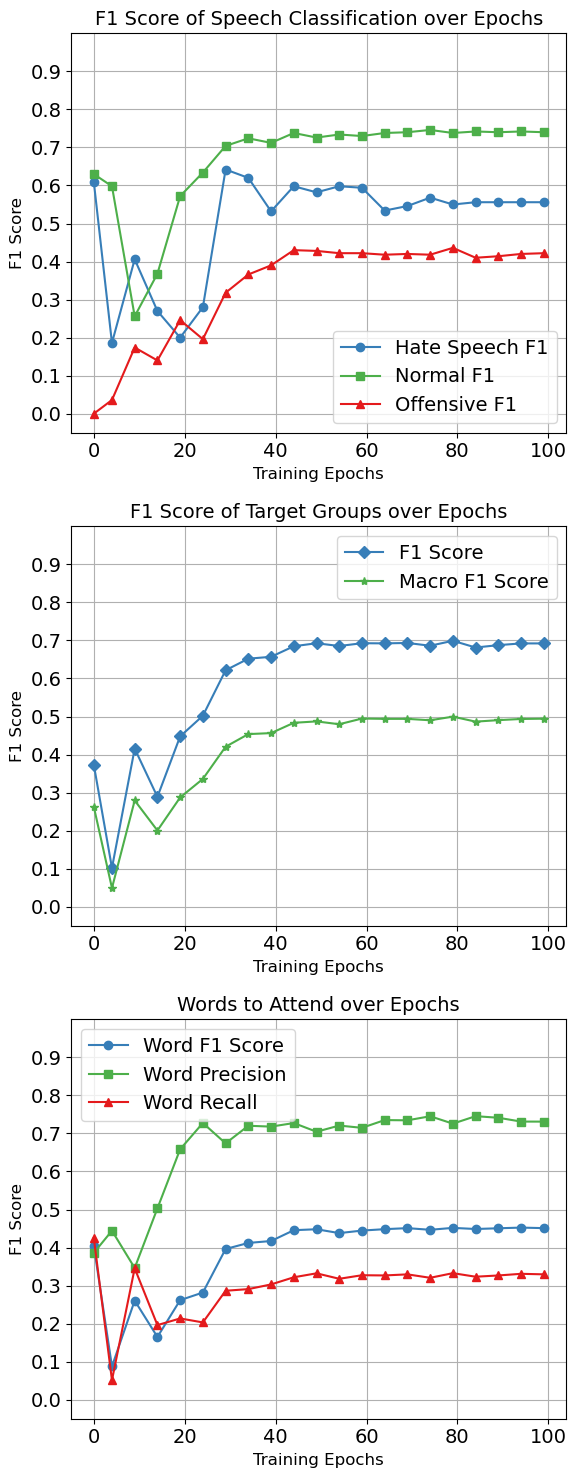

In [6]:
import csv
import re
import ast
import matplotlib.pyplot as plt

# CSV file path
directory_path = "logs/pfl_new/"

###############################################################################
# 1. Helper functions
###############################################################################
def extract_local_epoch(checkpoint_path):
    """Extracts the integer from 'checkpoint-<integer>' in the path."""
    match = re.search(r"checkpoint-(\d+)", checkpoint_path)
    return int(match.group(1)) if match else None

###############################################################################
# 2. We'll aggregate two sets of data:
#    (a) 3-class F1 from classification report lines
#    (b) Single + Macro F1 from columns in the CSV
###############################################################################
aggregated_3class = {}  # { local_step: {"hate_speech": [], "normal": [], "offensive": []} }
aggregated_single = {}  # { local_step: {"f1_scores": [], "macro_f1_scores": []} }

###############################################################################
# 3. Single pass over the CSV
###############################################################################
for filename in os.listdir(directory_path):
    csv_file_path = os.path.join(directory_path, filename)
    if filename.startswith("."):
        continue
    with open(csv_file_path, mode="r", encoding="utf-8") as file:
        reader = csv.DictReader(file)
        for row in reader:
            checkpoint_path = row.get("Checkpoint Path", "")
            if not checkpoint_path:
                continue

            # Extract local_step from checkpoint path
            local_epoch = extract_local_epoch(checkpoint_path)
            if local_epoch is None:
                continue

            # (a) Parse classification_report for hate/normal/offensive
            classification_report = row.get("Classification Report", "")
            if classification_report:
                # We'll search for lines with "hate speech", "normal", "offensive" 
                # and the 4th column is typically the F1 (index 3)
                f1_scores = {}
                for line in classification_report.split("\n"):
                    if "hate speech" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["hate_speech"] = float(parts[3])
                    elif "normal" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["normal"] = float(parts[3])
                    elif "offensive" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["offensive"] = float(parts[3])

                # If all three are found, store them
                if len(f1_scores) == 3:
                    if local_epoch not in aggregated_3class:
                        aggregated_3class[local_epoch] = {
                            "hate_speech": [],
                            "normal": [],
                            "offensive": []
                        }
                    aggregated_3class[local_epoch]["hate_speech"].append(f1_scores["hate_speech"])
                    aggregated_3class[local_epoch]["normal"].append(f1_scores["normal"])
                    aggregated_3class[local_epoch]["offensive"].append(f1_scores["offensive"])

            # (b) Parse single F1 + Macro F1 from CSV columns (if they exist)
            try:
                # f1_score = float(row["F1 Score"])
                # macro_f1_score = float(row["Macro F1 Score"])
                per_label = ast.literal_eval(row["Per Label F1"])
                f1_score, macro_f1_score = calculateF1Score(per_label)
                word_f1_score = float(row["Word F1 Score"])
                word_precision = float(row["Word Overall Precision"])
                word_recall = float(row["Word Overall Recall"])

            except (ValueError, KeyError):
                # If columns are missing or not numeric, skip
                continue

            if local_epoch not in aggregated_single:
                aggregated_single[local_epoch] = {
                    "f1_scores": [],
                    "macro_f1_scores": [],
                    "word_f1_scores": [],
                    "word_precision": [],
                    "word_recall":[]
                }
            aggregated_single[local_epoch]["f1_scores"].append(f1_score)
            aggregated_single[local_epoch]["macro_f1_scores"].append(macro_f1_score)
            aggregated_single[local_epoch]["word_f1_scores"].append(word_f1_score)
            aggregated_single[local_epoch]["word_precision"].append(word_precision)
            aggregated_single[local_epoch]["word_recall"].append(word_recall)

###############################################################################
# 4. Insert your "initial" data at local_step=0 if desired
###############################################################################
# For example, from your code snippet:
# (a) 3-class initial F1
initial_3class = {"hate_speech": 0.61, "normal": 0.63, "offensive": 0.0}
aggregated_3class[0] = {
    "hate_speech": [initial_3class["hate_speech"]],
    "normal": [initial_3class["normal"]],
    "offensive": [initial_3class["offensive"]]
}

# (b) Single F1 initial
aggregated_single[0] = {
    "f1_scores": [0.37347886270248776],
    "macro_f1_scores": [0.26300220119753553],
    "word_f1_scores":[0.4046881910659],
    "word_precision":[0.38591311682834245],
    "word_recall":[0.42538354253835425]
}

print(aggregated_3class[99])
print(aggregated_single[99])

df1 = pd.DataFrame(aggregated_3class[99])

df2 = pd.DataFrame(aggregated_single[99])

# Concatenate vertically
df_combined = pd.concat([df1, df2], axis=1)

# Save to CSV
df_combined.to_csv("pfl_new.csv", index=False)

###############################################################################
# 5. Compute averaged results from each dictionary and sort by local_step
###############################################################################
results_3class = []
for epoch, dict_scores in aggregated_3class.items():
    hs_list = dict_scores["hate_speech"]
    normal_list = dict_scores["normal"]
    off_list = dict_scores["offensive"]
    results_3class.append({
        "local_epoch": epoch,
        "hate_speech": sum(hs_list) / len(hs_list),
        "normal": sum(normal_list) / len(normal_list),
        "offensive": sum(off_list) / len(off_list)
    })

results_3class.sort(key=lambda x: x["local_epoch"])
results_single = []
for epoch, dict_scores in aggregated_single.items():
    f1_list = dict_scores["f1_scores"]
    macro_f1_list = dict_scores["macro_f1_scores"]
    word_f1_list = dict_scores["word_f1_scores"]
    word_precision_list = dict_scores["word_precision"]
    word_recall_list = dict_scores["word_recall"]
    results_single.append({
        "local_epoch": epoch,
        "F1 Score": sum(f1_list) / len(f1_list),
        "Macro F1 Score": sum(macro_f1_list) / len(macro_f1_list),
        "Word F1 Score": sum(word_f1_list)/len(word_f1_list),
        "Word Precision": sum(word_precision_list)/len(word_precision_list),
        "Word Recall": sum(word_recall_list)/len(word_recall_list)
    })

results_single.sort(key=lambda x: x["local_epoch"])
###############################################################################
# 6. Prepare data for plotting
###############################################################################
# For 3-class
epochs_3class_pfl_new = [item["local_epoch"] for item in results_3class]
f1_hate_speech_pfl_new = [item["hate_speech"] for item in results_3class]
f1_normal_pfl_new = [item["normal"] for item in results_3class]
f1_offensive_pfl_new = [item["offensive"] for item in results_3class]

# For single F1 + Macro F1
epochs_single_pfl_new = [item["local_epoch"] for item in results_single]
f1_score_vals_pfl_new = [item["F1 Score"] for item in results_single]
f1_macro_vals_pfl_new = [item["Macro F1 Score"] for item in results_single]
word_f1_score_vals_pfl_new = [item["Word F1 Score"] for item in results_single]
word_precision_vals_pfl_new = [item["Word Precision"] for item in results_single]
word_recall_vals_pfl_new = [item["Word Recall"] for item in results_single]
###############################################################################
# 7. (Optional) Convert local_steps to epochs if you want epochs on the X-axis
###############################################################################
# Example:
dataset_size = 15383
batch_size = 64

###############################################################################
# 8. Plot side by side in a single figure with two subplots
###############################################################################

# -- LEFT SUBPLOT: 3-class F1 lines
# Define colorblind-friendly palette and distinct markers
colors = ['#377eb8', '#4daf4a', '#e41a1c']  # blue, green, red
markers = ['o', 's', '^', 'D', '*']

fig, axs = plt.subplots(3, 1, figsize=(6, 15))

# -- LEFT SUBPLOT: 3-class F1
ax = axs[0]
ax.plot(epochs_3class_pfl_new, f1_hate_speech_pfl_new, label="Hate Speech F1", marker=markers[0], color=colors[0])
ax.plot(epochs_3class_pfl_new, f1_normal_pfl_new, label="Normal F1", marker=markers[1], color=colors[1])
ax.plot(epochs_3class_pfl_new, f1_offensive_pfl_new, label="Offensive F1", marker=markers[2], color=colors[2])

ax.set_title("F1 Score of Speech Classification over Epochs", fontsize=14)
ax.set_xlabel("Training Epochs", fontsize=12)
ax.set_ylabel("F1 Score", fontsize=12)
ax.set_ylim(-0.05, 1.0)
ax.set_yticks(np.arange(0, 1.0, 0.1))
ax.legend()
ax.grid(True)

# -- RIGHT SUBPLOT: single F1 + Macro F1 lines
ax_right = axs[1]
ax_right.plot(epochs_single_pfl_new, f1_score_vals_pfl_new, label="F1 Score", marker=markers[3], color=colors[0])
ax_right.plot(epochs_single_pfl_new, f1_macro_vals_pfl_new, label="Macro F1 Score", marker=markers[4], color=colors[1])

ax_right.set_title("F1 Score of Target Groups over Epochs", fontsize=14)
ax_right.set_xlabel("Training Epochs", fontsize=12)
ax_right.set_ylabel("F1 Score", fontsize=12)
ax_right.set_ylim(-0.05, 1.0)
ax_right.set_yticks(np.arange(0, 1.0, 0.1))
ax_right.legend()
ax_right.grid(True)

#Words
ax_left = axs[2]
ax_left.plot(epochs_single_pfl_new, word_f1_score_vals_pfl_new, label="Word F1 Score", marker=markers[0], color=colors[0])
ax_left.plot(epochs_single_pfl_new, word_precision_vals_pfl_new, label="Word Precision", marker=markers[1], color=colors[1])
ax_left.plot(epochs_single_pfl_new, word_recall_vals_pfl_new, label="Word Recall", marker=markers[2], color=colors[2])

ax_left.set_title("Words to Attend over Epochs", fontsize=14)
ax_left.set_xlabel("Training Epochs", fontsize=12)
ax_left.set_ylabel("F1 Score", fontsize=12)
ax_left.set_ylim(-0.05, 1.0)
ax_left.set_yticks(np.arange(0, 1.0, 0.1))
ax_left.legend()
ax_left.grid(True)

plt.rcParams.update({
    'font.size': 14,             # base font size
    'axes.titlesize': 14,        # subplot titles
    'axes.labelsize': 14,        # x/y axis labels
    'xtick.labelsize': 14,       # x tick labels
    'ytick.labelsize': 14,       # y tick labels
    'legend.fontsize': 14,       # legend text
})
plt.tight_layout()
# plt.savefig("central_model.png", dpi=300, bbox_inches='tight')
plt.show()

In [2]:

# Plot the results
colors = ['#377eb8', '#4daf4a', '#e41a1c']  # blue, green, red
markers = ['o', 's', '^', 'D', '*']
plt.figure(figsize=(6, 6))
# plt.plot(epochs_single_new, word_f1_score_vals_new, label="Word F1 Score", marker=markers[0], color=colors[0])
# plt.plot(epochs_single_new, word_precision_vals_new, label="Word Precision", marker=markers[1], color=colors[1])
# plt.plot(epochs_single_new, word_recall_vals_new, label="Word Recall", marker=markers[2], color=colors[2])
plt.plot(epochs_single_fl_new, f1_macro_vals_fl_new, label="Target Macro F1", marker=markers[0],color=colors[0])
plt.plot(epochs_single_pfl_new, f1_macro_vals_pfl_new, label="Target Macro F1", marker=markers[2],color=colors[2])
# plt.plot(epochs_single_dp, f1_macro_vals_dp, label="Target Macro F1", marker=markers[0], color=colors[0])
# plt.plot(epochs_single_new, f1_macro_vals_dp_new, label="Target Macro F1 (Explanation)", marker=markers[2], color=colors[2])

plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.ylim(-0.05, 1.0)
plt.yticks(np.arange(0, 1.0, 0.1))
plt.legend()
plt.grid(True)
plt.rcParams.update({
    'font.size': 14,             # base font size
    'axes.titlesize': 14,        # subplot titles
    'axes.labelsize': 14,        # x/y axis labels
    'xtick.labelsize': 14,       # x tick labels
    'ytick.labelsize': 14,       # y tick labels
    'legend.fontsize': 14,       # legend text
})
plt.tight_layout()
plt.savefig("fl_pfl_exp_macro.png", dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'epochs_single_fl_new' is not defined

<Figure size 600x600 with 0 Axes>

Clippig bound experiment

#Taking the average for clipping bound

{100.0: {'f1_scores': [0.0], 'macro_f1_scores': [0.0], 'word_f1_scores': [0.0], 'word_precision': [0.0], 'word_recall': [0.0]}, 1000.0: {'f1_scores': [0.0], 'macro_f1_scores': [0.0], 'word_f1_scores': [0.0], 'word_precision': [0.0], 'word_recall': [0.0]}, 10000.0: {'f1_scores': [0.7116727096040445], 'macro_f1_scores': [0.5357800187135157], 'word_f1_scores': [0.4963898916967509], 'word_precision': [0.7033248081841432], 'word_recall': [0.38354253835425384]}, 500.0: {'f1_scores': [0.0], 'macro_f1_scores': [0.0], 'word_f1_scores': [0.0], 'word_precision': [0.0], 'word_recall': [0.0]}, 5000.0: {'f1_scores': [0.6718337766399312], 'macro_f1_scores': [0.4559680394469854], 'word_f1_scores': [0.4475209272376046], 'word_precision': [0.7277486910994765], 'word_recall': [0.3231055323105532]}, 50000.0: {'f1_scores': [0.7166333198775181], 'macro_f1_scores': [0.5100275393698344], 'word_f1_scores': [0.46388542963885426], 'word_precision': [0.702167766258247], 'word_recall': [0.34635053463505344]}}


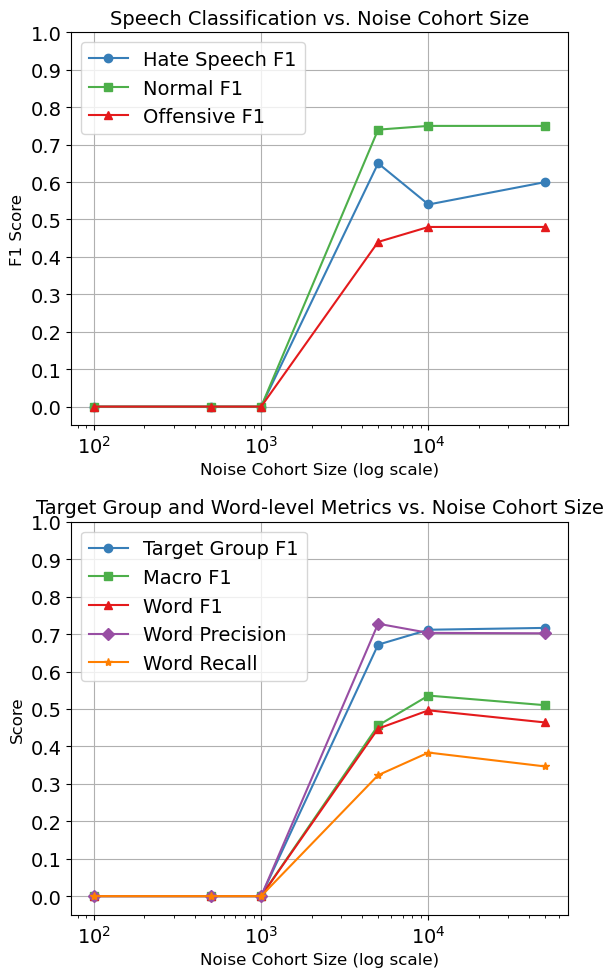

In [26]:
import csv
import re
import matplotlib.pyplot as plt
import glob
import os

# Directory containing all CSVs
csv_directory = "logs/pfl_new_experiments/noise_cohort_sizes/"

###############################################################################
# 1. Helper function to extract noise_cohort_size from checkpoint path
###############################################################################
def extract_noise_cohort_size(checkpoint_path):
    """
    Extracts noise_cohort_size from a path matching:
      .../pfl_noise_cohort_size_<int>/<float>/checkpoint-<int>
    Example path:
      logs/pfl_noise_cohort_size/pfl_noise_cohort_size_2/64/checkpoint-10
    which should yield 64 as a float.
    """
    match = re.search(r"pfl_noise_cohort_size_new_\d+/([^/]+)/checkpoint-\d+", checkpoint_path)
    if match:
        return float(match.group(1))
    return None

###############################################################################
# 2. Prepare two dictionaries for aggregated results:
#    (a) aggregated_3class for "hate_speech", "normal", "offensive"
#    (b) aggregated_single_f1 for "F1 Score" and "Macro F1 Score"
###############################################################################
aggregated_3class = {}
aggregated_single_f1 = {}

###############################################################################
# 3. Single pass over CSV files - parse both sets of scores.
###############################################################################
for csv_file_path in glob.glob(os.path.join(csv_directory, "*.csv")):
    with open(csv_file_path, mode="r", encoding="utf-8") as file:
        reader = csv.DictReader(file)
        for row in reader:
            checkpoint_path = row.get("Checkpoint Path", "")
            if not checkpoint_path:
                continue
            
            # Extract noise_cohort_size
            size = extract_noise_cohort_size(checkpoint_path)
            if size is None:
                continue

            # ---- (a) classification_report for 3 classes ----
            classification_report = row.get("Classification Report", "")
            if classification_report:
                f1_scores = {}
                for line in classification_report.split("\n"):
                    # Each line might look like "hate speech   0.90   0.92   0.91   100"
                    # The 4th column (index 3) is typically the F1
                    if "hate speech" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["hate_speech"] = float(parts[3])
                    elif "normal" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["normal"] = float(parts[3])
                    elif "offensive" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["offensive"] = float(parts[3])
                
                # If we successfully found all 3, store them
                if len(f1_scores) == 3:
                    if size not in aggregated_3class:
                        aggregated_3class[size] = {
                            "hate_speech": [],
                            "normal": [],
                            "offensive": []
                        }
                    aggregated_3class[size]["hate_speech"].append(f1_scores["hate_speech"])
                    aggregated_3class[size]["normal"].append(f1_scores["normal"])
                    aggregated_3class[size]["offensive"].append(f1_scores["offensive"])

            # ---- (b) Single F1 + Macro-F1 columns (if exist) ----
            try:
                per_label = ast.literal_eval(row["Per Label F1"])
                f1_score, macro_f1_score = calculateF1Score(per_label)
                word_f1_score = float(row["Word F1 Score"])
                word_precision = float(row["Word Overall Precision"])
                word_recall = float(row["Word Overall Recall"])

            except (ValueError, KeyError):
                # If columns don't exist or conversion fails, skip
                continue

            if size not in aggregated_single_f1:
                aggregated_single_f1[size] = {
                    "f1_scores": [],
                    "macro_f1_scores": [],
                    "word_f1_scores": [],
                    "word_precision": [],
                    "word_recall":[]
                }
            aggregated_single_f1[size]["f1_scores"].append(f1_score)
            aggregated_single_f1[size]["macro_f1_scores"].append(macro_f1_score)
            aggregated_single_f1[size]["word_f1_scores"].append(word_f1_score)
            aggregated_single_f1[size]["word_precision"].append(word_precision)
            aggregated_single_f1[size]["word_recall"].append(word_recall)
print(aggregated_single_f1)
###############################################################################
# 4. Compute average scores in each dictionary
###############################################################################
# (a) For "hate_speech", "normal", and "offensive"
results_3class = []
for size, scores_dict in aggregated_3class.items():
    hs_list = scores_dict["hate_speech"]
    normal_list = scores_dict["normal"]
    off_list = scores_dict["offensive"]
    results_3class.append({
        "noise_cohort_size": size,
        "hate_speech": sum(hs_list) / len(hs_list),
        "normal": sum(normal_list) / len(normal_list),
        "offensive": sum(off_list) / len(off_list),
    })

results_3class.sort(key=lambda x: x["noise_cohort_size"])

# (b) For single F1 and Macro-F1
results_single_f1 = []
for size, scores_dict in aggregated_single_f1.items():
    f1_list = scores_dict["f1_scores"]
    macro_f1_list = scores_dict["macro_f1_scores"]
    
    word_f1_list = scores_dict["word_f1_scores"]
    word_precision_list = scores_dict["word_precision"]
    word_recall_list = scores_dict["word_recall"]
    results_single_f1.append({
        "noise_cohort_size": size,
        "F1 Score": sum(f1_list) / len(f1_list),
        "Macro F1 Score": sum(macro_f1_list) / len(macro_f1_list),
        "Word F1 Score": sum(word_f1_list)/len(word_f1_list),
        "Word Precision": sum(word_precision_list)/len(word_precision_list),
        "Word Recall": sum(word_recall_list)/len(word_recall_list)
    })

results_single_f1.sort(key=lambda x: x["noise_cohort_size"])

###############################################################################
# 5. Plot them side by side in a single figure with two subplots
###############################################################################
colors = ['#377eb8', '#4daf4a', '#e41a1c', '#984ea3', '#ff7f00']
markers = ['o', 's', '^', 'D', '*']

fig, axs = plt.subplots(2, 1, figsize=(6, 10))

# --- Top subplot: Speech Classification ---
ax_top = axs[0]
sizes = [d["noise_cohort_size"] for d in results_3class]

ax_top.plot(sizes, [d["hate_speech"] for d in results_3class], label="Hate Speech F1", marker=markers[0], color=colors[0])
ax_top.plot(sizes, [d["normal"] for d in results_3class], label="Normal F1", marker=markers[1], color=colors[1])
ax_top.plot(sizes, [d["offensive"] for d in results_3class], label="Offensive F1", marker=markers[2], color=colors[2])

ax_top.set_xscale("log")
ax_top.set_ylim(-0.05, 1.0)
ax_top.set_yticks(np.arange(0, 1.1, 0.1))
ax_top.set_xlabel("Noise Cohort Size (log scale)", fontsize=12)
ax_top.set_ylabel("F1 Score", fontsize=12)
ax_top.set_title("Speech Classification vs. Noise Cohort Size", fontsize=14)
ax_top.grid(True)
ax_top.legend()

# --- Bottom subplot: Target Group + Word-Level ---
ax_bottom = axs[1]
sizes = [d["noise_cohort_size"] for d in results_single_f1]

ax_bottom.plot(sizes, [d["F1 Score"] for d in results_single_f1], label="Target Group F1", marker=markers[0], color=colors[0])
ax_bottom.plot(sizes, [d["Macro F1 Score"] for d in results_single_f1], label="Macro F1", marker=markers[1], color=colors[1])
ax_bottom.plot(sizes, [d["Word F1 Score"] for d in results_single_f1], label="Word F1", marker=markers[2], color=colors[2])
ax_bottom.plot(sizes, [d["Word Precision"] for d in results_single_f1], label="Word Precision", marker=markers[3], color=colors[3])
ax_bottom.plot(sizes, [d["Word Recall"] for d in results_single_f1], label="Word Recall", marker=markers[4], color=colors[4])

ax_bottom.set_xscale("log")
ax_bottom.set_ylim(-0.05, 1.0)
ax_bottom.set_yticks(np.arange(0, 1.1, 0.1))
ax_bottom.set_xlabel("Noise Cohort Size (log scale)", fontsize=12)
ax_bottom.set_ylabel("Score", fontsize=12)
ax_bottom.set_title("Target Group and Word-level Metrics vs. Noise Cohort Size", fontsize=14)
ax_bottom.grid(True)
ax_bottom.legend()

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})

plt.tight_layout()
plt.savefig("noise_cohort_size_new.png", dpi=300, bbox_inches="tight")
plt.show()


Epsilon

Average of epsilon

/tmp/sfaa2021/18822/ipykernel_1709296/4293223233.py:155: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_left.legend()
/tmp/sfaa2021/18822/ipykernel_1709296/4293223233.py:172: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()


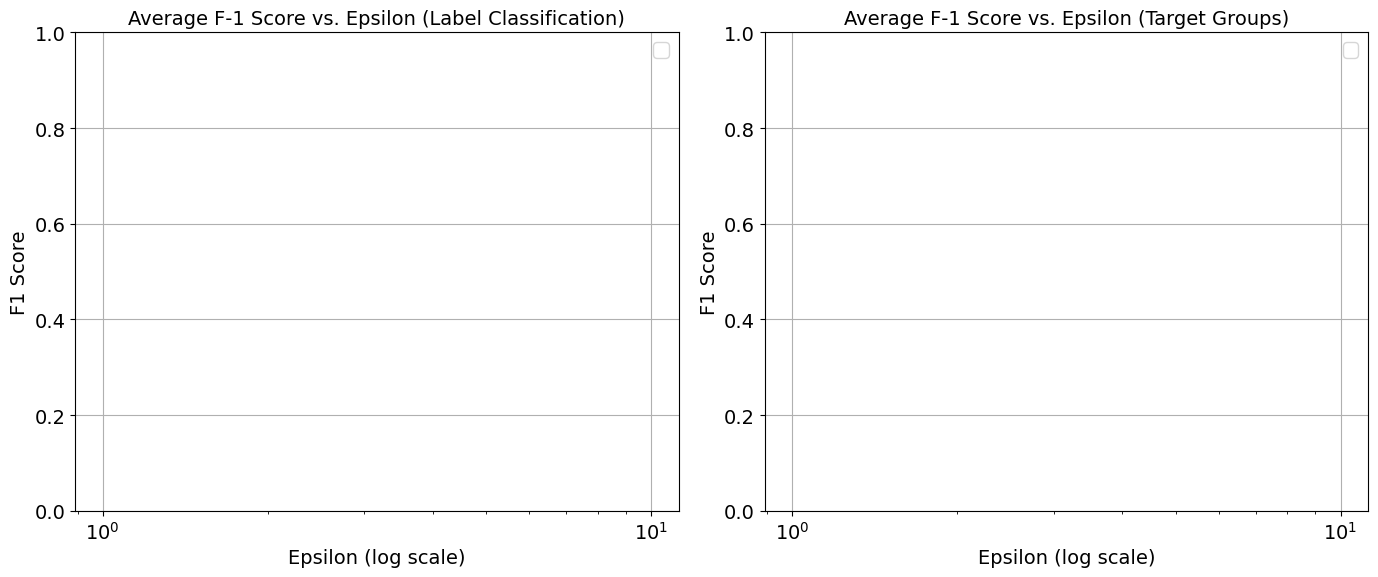

In [25]:
import csv
import re
import matplotlib.pyplot as plt
import glob
import os

# Directory containing all CSVs
csv_directory = "logs/pfl_new_experiments/"

###############################################################################
# 1. Define a helper to extract epsilon from the checkpoint path.
###############################################################################
def extract_epsilon(checkpoint_path):
    """
    Extracts epsilon from a path matching:
      .../pfl_epsilon_<integer>/<float>/checkpoint-<integer>
    Example path:
      pfl-epsilon/pfl_epsilon_2/0.01/checkpoint-99
    which should yield 0.01 as a float.
    """
    match = re.search(r"pfl_epsilon_\d+/([^/]+)/checkpoint-\d+", checkpoint_path)
    if match:
        return float(match.group(1))  # e.g. "0.01" -> 0.01
    return None

###############################################################################
# 2. Prepare two dictionaries:
#    (a) aggregated_3class for hate_speech, normal, offensive
#    (b) aggregated_single_f1 for "F1 Score" and "Macro F1 Score"
###############################################################################
aggregated_3class = {}
aggregated_single_f1 = {}

###############################################################################
# 3. Single pass over each CSV file, reading rows once and populating both.
###############################################################################
for csv_file_path in glob.glob(os.path.join(csv_directory, "*.csv")):
    with open(csv_file_path, mode="r", encoding="utf-8") as file:
        reader = csv.DictReader(file)
        for row in reader:
            checkpoint_path = row.get("Checkpoint Path", "")
            if not checkpoint_path:
                continue
            
            # Extract epsilon
            eps = extract_epsilon(checkpoint_path)
            if eps is None:
                continue

            # ------------------------
            # (a) Parse classification_report for hate/normal/offensive
            # ------------------------
            classification_report = row.get("Classification Report", "")
            if classification_report:
                f1_scores = {}
                for line in classification_report.split("\n"):
                    # Example line: "hate speech     0.90  0.92  0.91  100"
                    # The F1 is typically the 4th column (index 3)
                    if "hate speech" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["hate_speech"] = float(parts[3])
                    elif "normal" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["normal"] = float(parts[3])
                    elif "offensive" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["offensive"] = float(parts[3])
                
                # If we got all 3, store them
                if len(f1_scores) == 3:
                    if eps not in aggregated_3class:
                        aggregated_3class[eps] = {
                            "hate_speech": [],
                            "normal": [],
                            "offensive": []
                        }
                    aggregated_3class[eps]["hate_speech"].append(f1_scores["hate_speech"])
                    aggregated_3class[eps]["normal"].append(f1_scores["normal"])
                    aggregated_3class[eps]["offensive"].append(f1_scores["offensive"])

            # ------------------------
            # (b) Parse single F1 / macro F1 columns (if they exist)
            # ------------------------
            try:
                f1_score = float(row["F1 Score"])
                macro_f1_score = float(row["Macro F1 Score"])
            except (ValueError, KeyError):
                # If columns don't exist or aren't numeric, skip
                continue
            
            if eps not in aggregated_single_f1:
                aggregated_single_f1[eps] = {
                    "f1_scores": [],
                    "macro_f1_scores": []
                }
            aggregated_single_f1[eps]["f1_scores"].append(f1_score)
            aggregated_single_f1[eps]["macro_f1_scores"].append(macro_f1_score)

###############################################################################
# 4. Compute average scores in each dictionary
###############################################################################
# (a) 3-class approach
results_3class = []
for eps, scores_dict in aggregated_3class.items():
    hs_list = scores_dict["hate_speech"]
    normal_list = scores_dict["normal"]
    off_list = scores_dict["offensive"]
    results_3class.append({
        "epsilon": eps,
        "hate_speech": sum(hs_list) / len(hs_list),
        "normal": sum(normal_list) / len(normal_list),
        "offensive": sum(off_list) / len(off_list),
    })
results_3class.sort(key=lambda x: x["epsilon"])

# (b) Single F1 approach
results_single_f1 = []
for eps, scores_dict in aggregated_single_f1.items():
    f1_list = scores_dict["f1_scores"]
    macro_f1_list = scores_dict["macro_f1_scores"]
    avg_f1 = sum(f1_list) / len(f1_list)
    avg_macro_f1 = sum(macro_f1_list) / len(macro_f1_list)
    results_single_f1.append({
        "epsilon": eps,
        "F1 Score": avg_f1,
        "Macro F1 Score": avg_macro_f1
    })
results_single_f1.sort(key=lambda x: x["epsilon"])

###############################################################################
# 5. Plot them side by side using subplots
###############################################################################
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# -- Left subplot: 3-class F1 scores (hate, normal, offensive) --
ax_left = axs[0]
if len(results_3class) > 0:
    epsilons_3class = [d["epsilon"] for d in results_3class]
    f1_hate = [d["hate_speech"] for d in results_3class]
    f1_normal = [d["normal"] for d in results_3class]
    f1_offensive = [d["offensive"] for d in results_3class]

    ax_left.plot(epsilons_3class, f1_hate, label="Hate Speech F1", marker="o")
    ax_left.plot(epsilons_3class, f1_normal, label="Normal F1", marker="o")
    ax_left.plot(epsilons_3class, f1_offensive, label="Offensive F1", marker="o")
    
ax_left.set_xscale("log")
ax_left.set_title("Average F-1 Score vs. Epsilon (Label Classification)")
ax_left.set_xlabel("Epsilon (log scale)")
ax_left.set_ylabel("F1 Score")
ax_left.grid(True)
ax_left.legend()

# -- Right subplot: single + macro F1 scores --
ax_right = axs[1]
if len(results_single_f1) > 0:
    epsilons_single = [d["epsilon"] for d in results_single_f1]
    f1_values = [d["F1 Score"] for d in results_single_f1]
    macro_f1_values = [d["Macro F1 Score"] for d in results_single_f1]

    ax_right.plot(epsilons_single, f1_values, label="F1 Score", marker="o")
    ax_right.plot(epsilons_single, macro_f1_values, label="Macro F1 Score", marker="o")

ax_right.set_xscale("log")
ax_right.set_title("Average F-1 Score vs. Epsilon (Target Groups)")
ax_right.set_xlabel("Epsilon (log scale)")
ax_right.set_ylabel("F1 Score")
ax_right.grid(True)
ax_right.legend()

plt.tight_layout()
plt.show()


Noise Cohort Size

Average of Noise Cohort Size

{0.05: {'f1_scores': [0.7117088572048363, 0.6405541496083792], 'macro_f1_scores': [0.49763673079198045, 0.4456168239263854], 'word_f1_scores': [0.4830547462045698, 0.4168658245134858], 'word_precision': [0.7097791798107256, 0.7847043701799485], 'word_recall': [0.36610878661087864, 0.28382147838214783]}, 0.1: {'f1_scores': [0.6786339752336589, 0.7350586243996683], 'macro_f1_scores': [0.473556438765716, 0.521045503378457], 'word_f1_scores': [0.45195387572069184, 0.5051124744376279], 'word_precision': [0.7265705458290422, 0.6796383647798742], 'word_recall': [0.32798698279869826, 0.401906090190609]}, 0.5: {'f1_scores': [0.0, 0.0], 'macro_f1_scores': [0.0, 0.0], 'word_f1_scores': [0.0, 0.0], 'word_precision': [0.0, 0.0], 'word_recall': [0.0, 0.0]}, 1.0: {'f1_scores': [0.0, 0.0], 'macro_f1_scores': [0.0, 0.0], 'word_f1_scores': [0.0, 0.0], 'word_precision': [0.0, 0.0], 'word_recall': [0.0, 0.0]}, 10.0: {'f1_scores': [0.0, 0.0], 'macro_f1_scores': [0.0, 0.0], 'word_f1_scores': [0.0, 0.0], 'wo

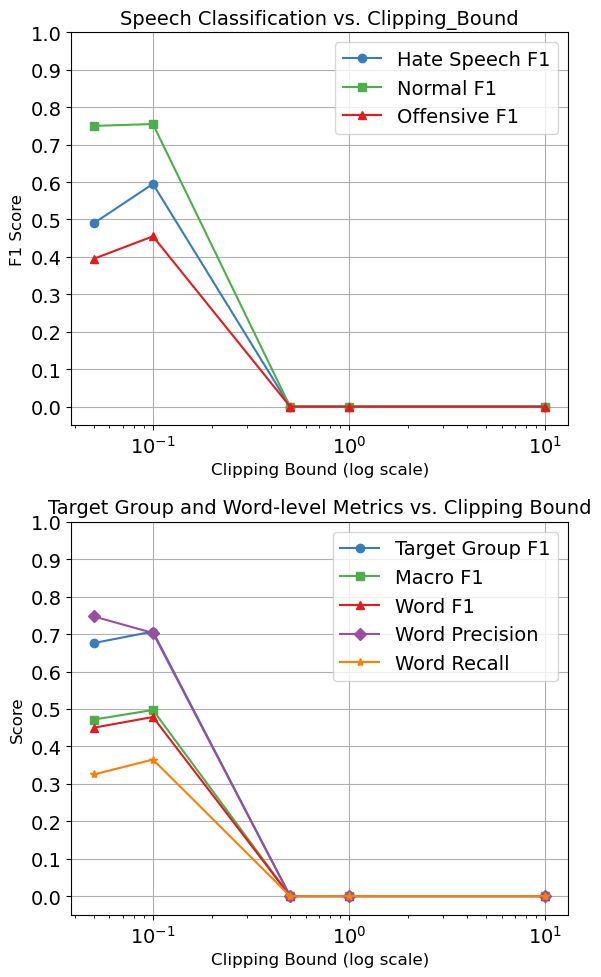

In [27]:
import csv
import re
import matplotlib.pyplot as plt
import glob
import os

# Directory containing all CSVs
csv_directory = "logs/pfl_new_experiments/clipping_bounds/"

###############################################################################
# 1. Helper function to extract noise_cohort_size from checkpoint path
###############################################################################
# 1. Define a helper to extract the clipping bound from a path.
def extract_clipping_bound(checkpoint_path):
    """
    Extracts the clipping bound from a path matching:
      .../pfl_clipping_bound_<integer>/<float>/checkpoint-<integer>
    Example path:
      pfl-research/benchmarks/hf_checkpoint/clipping_bounds/pfl_clipping_bound_2/0.01/checkpoint-99
    which should yield 0.01 as a float.
    """
    match = re.search(r"pfl_clipping_bound_new_\d+/([^/]+)/checkpoint-\d+", checkpoint_path)
    if match:
        return float(match.group(1))  # e.g. "0.01" -> 0.01
    return None

###############################################################################
# 2. Prepare two dictionaries for aggregated results:
#    (a) aggregated_3class for "hate_speech", "normal", "offensive"
#    (b) aggregated_single_f1 for "F1 Score" and "Macro F1 Score"
###############################################################################
aggregated_3class = {}
aggregated_single_f1 = {}

###############################################################################
# 3. Single pass over CSV files - parse both sets of scores.
###############################################################################
for csv_file_path in glob.glob(os.path.join(csv_directory, "*.csv")):
    with open(csv_file_path, mode="r", encoding="utf-8") as file:
        reader = csv.DictReader(file)
        for row in reader:
            checkpoint_path = row.get("Checkpoint Path", "")
            if not checkpoint_path:
                continue
            
            # Extract noise_cohort_size
            size = extract_clipping_bound(checkpoint_path)
            if size is None:
                continue

            # ---- (a) classification_report for 3 classes ----
            classification_report = row.get("Classification Report", "")
            if classification_report:
                f1_scores = {}
                for line in classification_report.split("\n"):
                    # Each line might look like "hate speech   0.90   0.92   0.91   100"
                    # The 4th column (index 3) is typically the F1
                    if "hate speech" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["hate_speech"] = float(parts[3])
                    elif "normal" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["normal"] = float(parts[3])
                    elif "offensive" in line:
                        parts = line.split()
                        if len(parts) >= 4:
                            f1_scores["offensive"] = float(parts[3])
                
                # If we successfully found all 3, store them
                if len(f1_scores) == 3:
                    if size not in aggregated_3class:
                        aggregated_3class[size] = {
                            "hate_speech": [],
                            "normal": [],
                            "offensive": []
                        }
                    aggregated_3class[size]["hate_speech"].append(f1_scores["hate_speech"])
                    aggregated_3class[size]["normal"].append(f1_scores["normal"])
                    aggregated_3class[size]["offensive"].append(f1_scores["offensive"])

            # ---- (b) Single F1 + Macro-F1 columns (if exist) ----
            try:
                per_label = ast.literal_eval(row["Per Label F1"])
                f1_score, macro_f1_score = calculateF1Score(per_label)
                word_f1_score = float(row["Word F1 Score"])
                word_precision = float(row["Word Overall Precision"])
                word_recall = float(row["Word Overall Recall"])

            except (ValueError, KeyError):
                # If columns don't exist or conversion fails, skip
                continue

            if size not in aggregated_single_f1:
                aggregated_single_f1[size] = {
                    "f1_scores": [],
                    "macro_f1_scores": [],
                    "word_f1_scores": [],
                    "word_precision": [],
                    "word_recall":[]
                }
            aggregated_single_f1[size]["f1_scores"].append(f1_score)
            aggregated_single_f1[size]["macro_f1_scores"].append(macro_f1_score)
            aggregated_single_f1[size]["word_f1_scores"].append(word_f1_score)
            aggregated_single_f1[size]["word_precision"].append(word_precision)
            aggregated_single_f1[size]["word_recall"].append(word_recall)
print(aggregated_single_f1)
###############################################################################
# 4. Compute average scores in each dictionary
###############################################################################
# (a) For "hate_speech", "normal", and "offensive"
results_3class = []
for size, scores_dict in aggregated_3class.items():
    hs_list = scores_dict["hate_speech"]
    normal_list = scores_dict["normal"]
    off_list = scores_dict["offensive"]
    results_3class.append({
        "clipping_bound": size,
        "hate_speech": sum(hs_list) / len(hs_list),
        "normal": sum(normal_list) / len(normal_list),
        "offensive": sum(off_list) / len(off_list),
    })

results_3class.sort(key=lambda x: x["clipping_bound"])

# (b) For single F1 and Macro-F1
results_single_f1 = []
for size, scores_dict in aggregated_single_f1.items():
    f1_list = scores_dict["f1_scores"]
    macro_f1_list = scores_dict["macro_f1_scores"]
    
    word_f1_list = scores_dict["word_f1_scores"]
    word_precision_list = scores_dict["word_precision"]
    word_recall_list = scores_dict["word_recall"]
    results_single_f1.append({
        "clipping_bound": size,
        "F1 Score": sum(f1_list) / len(f1_list),
        "Macro F1 Score": sum(macro_f1_list) / len(macro_f1_list),
        "Word F1 Score": sum(word_f1_list)/len(word_f1_list),
        "Word Precision": sum(word_precision_list)/len(word_precision_list),
        "Word Recall": sum(word_recall_list)/len(word_recall_list)
    })

results_single_f1.sort(key=lambda x: x["clipping_bound"])

###############################################################################
# 5. Plot them side by side in a single figure with two subplots
###############################################################################
colors = ['#377eb8', '#4daf4a', '#e41a1c', '#984ea3', '#ff7f00']
markers = ['o', 's', '^', 'D', '*']

fig, axs = plt.subplots(2, 1, figsize=(6, 10))

# --- Top subplot: Speech Classification ---
ax_top = axs[0]
sizes = [d["clipping_bound"] for d in results_3class]

ax_top.plot(sizes, [d["hate_speech"] for d in results_3class], label="Hate Speech F1", marker=markers[0], color=colors[0])
ax_top.plot(sizes, [d["normal"] for d in results_3class], label="Normal F1", marker=markers[1], color=colors[1])
ax_top.plot(sizes, [d["offensive"] for d in results_3class], label="Offensive F1", marker=markers[2], color=colors[2])

ax_top.set_xscale("log")
ax_top.set_ylim(-0.05, 1.0)
ax_top.set_yticks(np.arange(0, 1.1, 0.1))
ax_top.set_xlabel("Clipping Bound (log scale)", fontsize=12)
ax_top.set_ylabel("F1 Score", fontsize=12)
ax_top.set_title("Speech Classification vs. Clipping_Bound", fontsize=14)
ax_top.grid(True)
ax_top.legend()

# --- Bottom subplot: Target Group + Word-Level ---
ax_bottom = axs[1]
sizes = [d["clipping_bound"] for d in results_single_f1]

ax_bottom.plot(sizes, [d["F1 Score"] for d in results_single_f1], label="Target Group F1", marker=markers[0], color=colors[0])
ax_bottom.plot(sizes, [d["Macro F1 Score"] for d in results_single_f1], label="Macro F1", marker=markers[1], color=colors[1])
ax_bottom.plot(sizes, [d["Word F1 Score"] for d in results_single_f1], label="Word F1", marker=markers[2], color=colors[2])
ax_bottom.plot(sizes, [d["Word Precision"] for d in results_single_f1], label="Word Precision", marker=markers[3], color=colors[3])
ax_bottom.plot(sizes, [d["Word Recall"] for d in results_single_f1], label="Word Recall", marker=markers[4], color=colors[4])

ax_bottom.set_xscale("log")
ax_bottom.set_ylim(-0.05, 1.0)
ax_bottom.set_yticks(np.arange(0, 1.1, 0.1))
ax_bottom.set_xlabel("Clipping Bound (log scale)", fontsize=12)
ax_bottom.set_ylabel("Score", fontsize=12)
ax_bottom.set_title("Target Group and Word-level Metrics vs. Clipping Bound", fontsize=14)
ax_bottom.grid(True)
ax_bottom.legend()

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})

plt.tight_layout()
plt.savefig("clipping_bound_new.png", dpi=300, bbox_inches="tight")
plt.show()


# With DP to central model

No attention, wrong regular mistral

[{'local_epoch': 0, 'hate_speech': 0.61, 'normal': 0.63, 'offensive': 0.0}, {'local_epoch': 1, 'hate_speech': 0.83, 'normal': 0.65, 'offensive': 0.03}, {'local_epoch': 2, 'hate_speech': 0.47, 'normal': 0.65, 'offensive': 0.0}, {'local_epoch': 3, 'hate_speech': 0.54, 'normal': 0.66, 'offensive': 0.0}, {'local_epoch': 4, 'hate_speech': 0.49, 'normal': 0.65, 'offensive': 0.0}, {'local_epoch': 5, 'hate_speech': 0.61, 'normal': 0.67, 'offensive': 0.0}, {'local_epoch': 10, 'hate_speech': 0.58, 'normal': 0.67, 'offensive': 0.01}, {'local_epoch': 15, 'hate_speech': 0.74, 'normal': 0.71, 'offensive': 0.0}, {'local_epoch': 20, 'hate_speech': 0.59, 'normal': 0.69, 'offensive': 0.0}, {'local_epoch': 25, 'hate_speech': 0.58, 'normal': 0.67, 'offensive': 0.0}, {'local_epoch': 30, 'hate_speech': 0.77, 'normal': 0.71, 'offensive': 0.0}, {'local_epoch': 35, 'hate_speech': 0.94, 'normal': 0.71, 'offensive': 0.08}, {'local_epoch': 40, 'hate_speech': 0.92, 'normal': 0.72, 'offensive': 0.11}, {'local_epoch

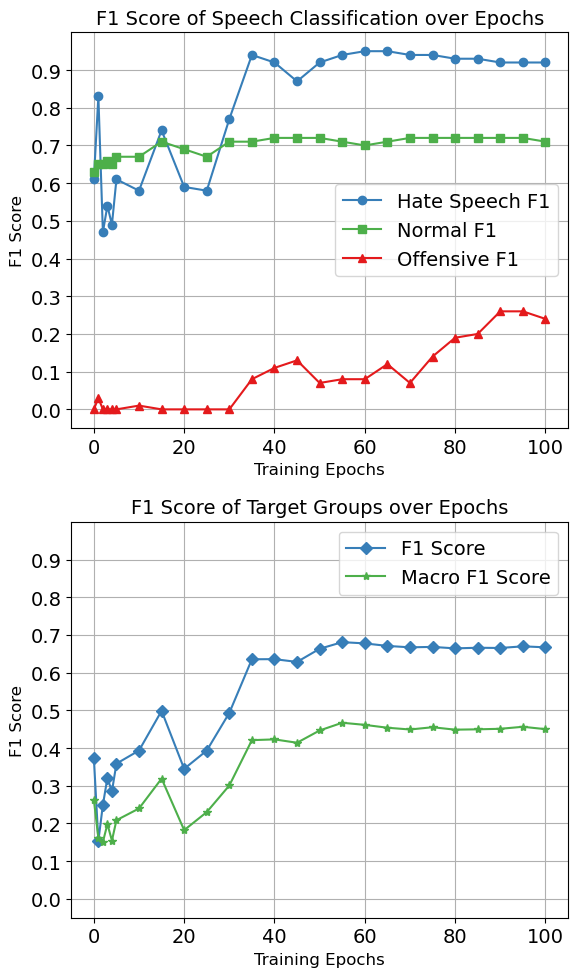

In [36]:
import csv
import re
import ast
import matplotlib.pyplot as plt

# CSV file path
csv_file_path = "logs/central_learning/mistral_dp_new_evaluation.csv"

###############################################################################
# 1. Helper functions
###############################################################################
def extract_epoch(checkpoint_path):
    """
    Extracts the integer from 'lora_epoch-<integer>' in the path.
    For example: '.../lora_epoch-5/checkpoint-xxx' -> 5
    """
    match = re.search(r"lora_epoch-(\d+)", checkpoint_path)
    return int(match.group(1)) if match else None

###############################################################################
# 2. We'll aggregate two sets of data:
#    (a) 3-class F1 from classification report lines
#    (b) Single + Macro F1 from columns in the CSV
###############################################################################
aggregated_3class = {}  # { local_step: {"hate_speech": [], "normal": [], "offensive": []} }
aggregated_single = {}  # { local_step: {"f1_scores": [], "macro_f1_scores": []} }

###############################################################################
# 3. Single pass over the CSV
###############################################################################
with open(csv_file_path, mode="r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    for row in reader:
        checkpoint_path = row.get("Checkpoint Path", "")
        if not checkpoint_path:
            continue
        
        # Extract local_step from checkpoint path
        local_epoch = extract_epoch(checkpoint_path)
        if local_epoch is None:
            continue
        
        # (a) Parse classification_report for hate/normal/offensive
        classification_report = row.get("Classification Report", "")
        if classification_report:
            # We'll search for lines with "hate speech", "normal", "offensive" 
            # and the 4th column is typically the F1 (index 3)
            f1_scores = {}
            for line in classification_report.split("\n"):
                if "hate speech" in line:
                    parts = line.split()
                    if len(parts) >= 4:
                        f1_scores["hate_speech"] = float(parts[3])
                elif "normal" in line:
                    parts = line.split()
                    if len(parts) >= 4:
                        f1_scores["normal"] = float(parts[3])
                elif "offensive" in line:
                    parts = line.split()
                    if len(parts) >= 4:
                        f1_scores["offensive"] = float(parts[3])
            
            # If all three are found, store them
            if len(f1_scores) == 3:
                if local_epoch not in aggregated_3class:
                    aggregated_3class[local_epoch] = {
                        "hate_speech": [],
                        "normal": [],
                        "offensive": []
                    }
                aggregated_3class[local_epoch]["hate_speech"].append(f1_scores["hate_speech"])
                aggregated_3class[local_epoch]["normal"].append(f1_scores["normal"])
                aggregated_3class[local_epoch]["offensive"].append(f1_scores["offensive"])
        
        # (b) Parse single F1 + Macro F1 from CSV columns (if they exist)
        try:
            # f1_score = float(row["F1 Score"])
            # macro_f1_score = float(row["Macro F1 Score"])
            per_label = ast.literal_eval(row["Per Label F1"])
            f1_score, macro_f1_score = calculateF1Score(per_label)
            word_f1_score = float(row["Word F1 Score"])
            word_precision = float(row["Word Overall Precision"])
            word_recall = float(row["Word Overall Recall"])

        except (ValueError, KeyError):
            # If columns are missing or not numeric, skip
            continue
        
        if local_epoch not in aggregated_single:
            aggregated_single[local_epoch] = {
                "f1_scores": [],
                "macro_f1_scores": [],
                "word_f1_scores": [],
                "word_precision": [],
                "word_recall":[]
            }
        aggregated_single[local_epoch]["f1_scores"].append(f1_score)
        aggregated_single[local_epoch]["macro_f1_scores"].append(macro_f1_score)
        aggregated_single[local_epoch]["word_f1_scores"].append(word_f1_score)
        aggregated_single[local_epoch]["word_precision"].append(word_precision)
        aggregated_single[local_epoch]["word_recall"].append(word_recall)

###############################################################################
# 4. Insert your "initial" data at local_step=0 if desired
###############################################################################
# For example, from your code snippet:
# (a) 3-class initial F1
initial_3class = {"hate_speech": 0.61, "normal": 0.63, "offensive": 0.0}
aggregated_3class[0] = {
    "hate_speech": [initial_3class["hate_speech"]],
    "normal": [initial_3class["normal"]],
    "offensive": [initial_3class["offensive"]]
}

# (b) Single F1 initial
aggregated_single[0] = {
    "f1_scores": [0.37347886270248776],
    "macro_f1_scores": [0.26300220119753553],
    "word_f1_scores":[0.4046881910659],
    "word_precision":[0.38591311682834245],
    "word_recall":[0.42538354253835425]
}
df1 = pd.DataFrame(aggregated_3class[100])

df2 = pd.DataFrame(aggregated_single[100])

# Concatenate vertically
df_combined = pd.concat([df1, df2], axis=1)

# Save to CSV
df_combined.to_csv("dp_central_new.csv", index=False)
###############################################################################
# 5. Compute averaged results from each dictionary and sort by local_step
###############################################################################
results_3class = []
for epoch, dict_scores in aggregated_3class.items():
    hs_list = dict_scores["hate_speech"]
    normal_list = dict_scores["normal"]
    off_list = dict_scores["offensive"]
    results_3class.append({
        "local_epoch": epoch,
        "hate_speech": sum(hs_list) / len(hs_list),
        "normal": sum(normal_list) / len(normal_list),
        "offensive": sum(off_list) / len(off_list)
    })

results_3class.sort(key=lambda x: x["local_epoch"])
print(results_3class)
results_single = []
for epoch, dict_scores in aggregated_single.items():
    f1_list = dict_scores["f1_scores"]
    macro_f1_list = dict_scores["macro_f1_scores"]
    word_f1_list = dict_scores["word_f1_scores"]
    word_precision_list = dict_scores["word_precision"]
    word_recall_list = dict_scores["word_recall"]
    results_single.append({
        "local_epoch": epoch,
        "F1 Score": sum(f1_list) / len(f1_list),
        "Macro F1 Score": sum(macro_f1_list) / len(macro_f1_list),
        "Word F1 Score": sum(word_f1_list)/len(word_f1_list),
        "Word Precision": sum(word_precision_list)/len(word_precision_list),
        "Word Recall": sum(word_recall_list)/len(word_recall_list)
    })

results_single.sort(key=lambda x: x["local_epoch"])
print(results_single)
###############################################################################
# 6. Prepare data for plotting
###############################################################################
# For 3-class
epochs_3class_dp_new = [item["local_epoch"] for item in results_3class]
f1_hate_speech_dp_new = [item["hate_speech"] for item in results_3class]
f1_normal_dp_new = [item["normal"] for item in results_3class]
f1_offensive_dp_new = [item["offensive"] for item in results_3class]

# For single F1 + Macro F1
epochs_single_dp_new = [item["local_epoch"] for item in results_single]
f1_score_vals_dp_new = [item["F1 Score"] for item in results_single]
f1_macro_vals_dp_new = [item["Macro F1 Score"] for item in results_single]
word_precision_vals_dp_new = [item["Word Precision"] for item in results_single]
word_recall_vals_dp_new = [item["Word Recall"] for item in results_single]
###############################################################################
# 8. Plot side by side in a single figure with two subplots
###############################################################################

# -- LEFT SUBPLOT: 3-class F1 lines
# Define colorblind-friendly palette and distinct markers
colors = ['#377eb8', '#4daf4a', '#e41a1c']  # blue, green, red
markers = ['o', 's', '^', 'D', '*']

fig, axs = plt.subplots(2, 1, figsize=(6, 10))

# -- LEFT SUBPLOT: 3-class F1
ax_left = axs[0]
ax_left.plot(epochs_3class_dp_new, f1_hate_speech_dp_new, label="Hate Speech F1", marker=markers[0], color=colors[0])
ax_left.plot(epochs_3class_dp_new, f1_normal_dp_new, label="Normal F1", marker=markers[1], color=colors[1])
ax_left.plot(epochs_3class_dp_new, f1_offensive_dp_new, label="Offensive F1", marker=markers[2], color=colors[2])

ax_left.set_title("F1 Score of Speech Classification over Epochs", fontsize=14)
ax_left.set_xlabel("Training Epochs", fontsize=12)
ax_left.set_ylabel("F1 Score", fontsize=12)
ax_left.set_ylim(-0.05, 1.0)
ax_left.set_yticks(np.arange(0, 1.0, 0.1))
ax_left.legend()
ax_left.grid(True)

# -- RIGHT SUBPLOT: single F1 + Macro F1 lines
ax_right = axs[1]
ax_right.plot(epochs_single_dp_new, f1_score_vals_dp_new, label="F1 Score", marker=markers[3], color=colors[0])
ax_right.plot(epochs_single_dp_new, f1_macro_vals_dp_new, label="Macro F1 Score", marker=markers[4], color=colors[1])

ax_right.set_title("F1 Score of Target Groups over Epochs", fontsize=14)
ax_right.set_xlabel("Training Epochs", fontsize=12)
ax_right.set_ylabel("F1 Score", fontsize=12)
ax_right.set_ylim(-0.05, 1.0)
ax_right.set_yticks(np.arange(0, 1.0, 0.1))
ax_right.legend()
ax_right.grid(True)

plt.rcParams.update({
    'font.size': 14,             # base font size
    'axes.titlesize': 14,        # subplot titles
    'axes.labelsize': 14,        # x/y axis labels
    'xtick.labelsize': 14,       # x tick labels
    'ytick.labelsize': 14,       # y tick labels
    'legend.fontsize': 14,       # legend text
})
plt.tight_layout()
plt.savefig("central_dp_model_new.png", dpi=300, bbox_inches='tight')
plt.show()


No attention, regular mistral


[{'local_step': 0, 'hate_speech': 0.55, 'normal': 0.46, 'offensive': 0}, {'local_step': 481, 'hate_speech': 0.8, 'normal': 0.77, 'offensive': 0.47}, {'local_step': 962, 'hate_speech': 0.86, 'normal': 0.77, 'offensive': 0.53}, {'local_step': 1443, 'hate_speech': 0.83, 'normal': 0.73, 'offensive': 0.57}, {'local_step': 1924, 'hate_speech': 0.63, 'normal': 0.77, 'offensive': 0.57}, {'local_step': 2405, 'hate_speech': 0.7, 'normal': 0.75, 'offensive': 0.59}, {'local_step': 4810, 'hate_speech': 0.73, 'normal': 0.75, 'offensive': 0.55}, {'local_step': 7215, 'hate_speech': 0.82, 'normal': 0.76, 'offensive': 0.54}, {'local_step': 9620, 'hate_speech': 0.7, 'normal': 0.74, 'offensive': 0.57}, {'local_step': 12025, 'hate_speech': 0.78, 'normal': 0.76, 'offensive': 0.54}, {'local_step': 14430, 'hate_speech': 0.82, 'normal': 0.75, 'offensive': 0.57}, {'local_step': 16835, 'hate_speech': 0.65, 'normal': 0.74, 'offensive': 0.55}, {'local_step': 19240, 'hate_speech': 0.73, 'normal': 0.75, 'offensive':

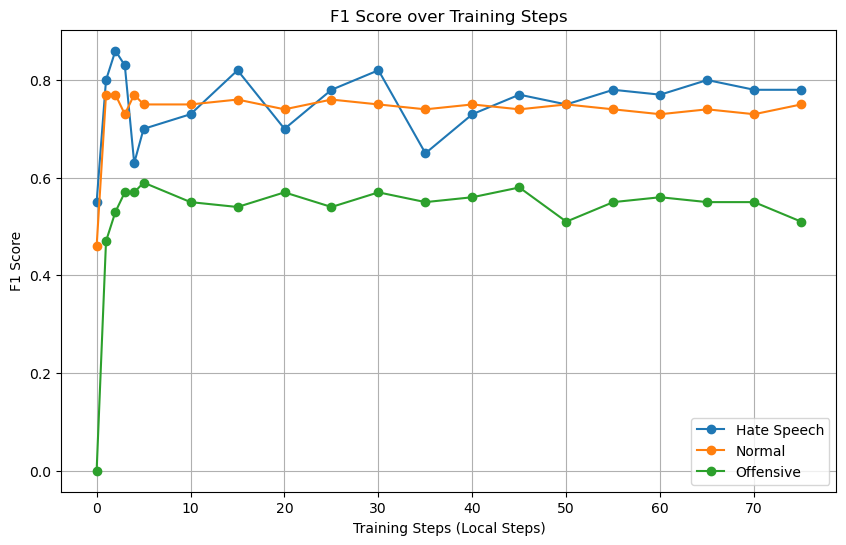

In [49]:
import csv
import re
import matplotlib.pyplot as plt

# File path
csv_file_path = "mistral_evaluation.csv"

# Initialize storage for results
results = []

def local_step_to_epoch(local_step, batch_size, dataset_size):
    return (local_step * batch_size) / dataset_size

# Function to extract the last number from the Checkpoint Path
def extract_local_step(checkpoint_path):
    match = re.search(r"checkpoint-(\d+)", checkpoint_path)
    return int(match.group(1)) if match else None

# Read the CSV file
with open(csv_file_path, mode="r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        checkpoint_path = row["Checkpoint Path"]
        classification_report = row["Classification Report"]
        
        # Extract the local step
        local_step = extract_local_step(checkpoint_path)
        
        # Extract F1 scores for "hate speech," "normal," and "offensive"
        f1_scores = {}
        for line in classification_report.split("\n"):
            if "hate speech" in line:
                f1_scores["hate_speech"] = float(line.split()[3])
            elif "normal" in line:
                f1_scores["normal"] = float(line.split()[3])
            elif "offensive" in line:
                f1_scores["offensive"] = float(line.split()[3])
        
        # Append to results if all scores are found
        if f1_scores and local_step is not None:
            results.append({"local_step": local_step, **f1_scores})

f1_scores_initial = {"hate_speech": 0.55 , "normal": 0.46 , "offensive": 0}
results.append({"local_step": 0, **f1_scores_initial})
# Sort results by local_step
results.sort(key=lambda x: x["local_step"])
print(results)
# Extract data for plotting
steps = [item["local_step"] for item in results]
dataset_size = 15383  # Replace with your dataset size
epochs = [local_step_to_epoch(step, 32, dataset_size) for step in steps]

f1_hate_speech = [item["hate_speech"] for item in results]
f1_normal = [item["normal"] for item in results]
f1_offensive = [item["offensive"] for item in results]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_hate_speech, label="Hate Speech", marker="o")
plt.plot(epochs, f1_normal, label="Normal", marker="o")
plt.plot(epochs, f1_offensive, label="Offensive", marker="o")

# Customize the plot
plt.title("F1 Score over Training Steps")
plt.xlabel("Training Steps (Local Steps)")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()


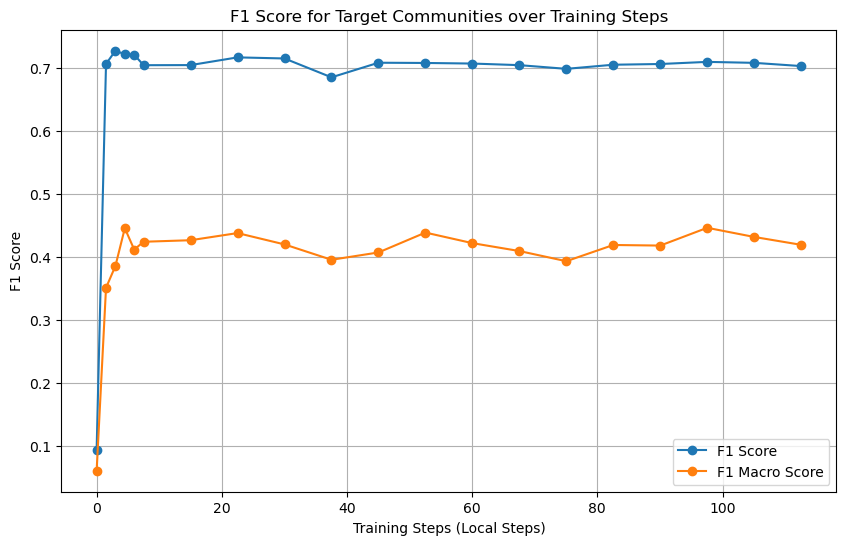

In [50]:
# Read the CSV file
csv_file_path = "mistral_evaluation.csv"
results= []
with open(csv_file_path, mode="r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        checkpoint_path = row["Checkpoint Path"]
        f1_score = float(row["F1 Score"])  # Convert to float
        macro_f1_score = float(row["Macro F1 Score"])  # Convert to float
        
        # Extract the local step
        local_step = extract_local_step(checkpoint_path)

        
        # Append to results if all scores are found
        if f1_scores and local_step is not None:
            results.append({"local_step": local_step, "F1 Score": f1_score, "Macro F1 Score": macro_f1_score})

results.append({"local_step": 0,  "F1 Score": 0.09410175596578119, "Macro F1 Score": 0.06087993476610173})
# Sort results by local_step
results.sort(key=lambda x: x["local_step"])

# Extract data for plotting
steps = [item["local_step"] for item in results]
dataset_size = 15383  # Replace with your dataset size
epochs = [local_step_to_epoch(step, 48, dataset_size) for step in steps]

f1_score = [item["F1 Score"] for item in results]
f1_macro_score = [item["Macro F1 Score"] for item in results]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_score, label="F1 Score", marker="o")
plt.plot(epochs, f1_macro_score, label="F1 Macro Score", marker="o")

# Customize the plot
plt.title("F1 Score for Target Communities over Training Steps")
plt.xlabel("Training Steps (Local Steps)")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()
